# Media Sentiment & Topic Analysis to Inform Food Policy

### Linking news sentiment & volume to near‑term U.S. food policy activity

**Author:** Jasmine Motupalli

**Research question:** How do shifts in media attention and sentiment correspond with policy actions or public engagement on food security, and can these patterns be leveraged to anticipate or influence advocacy efforts?

**Purpose:** This notebook shows how to programmatically ingest open media and policy data, engineer features, and train a predictive model (Random Forest / LightGBM) that forecasts near‑term federal food policy activity (e.g., SNAP/WIC proposed/final rules) based on media sentiment and volume.

**Outputs:**
- Feature dataset at daily/weekly frequency
- Trained model and evaluation metrics
- CSVs ready for an interactive dashboard (e.g., Shiny)

---
### Data Sources (APIs)
- **GDELT DOC 2.0 API** for global online news timeseries (volume & sentiment/tone). Docs and examples: <https://blog.gdeltproject.org/gdelt-doc-2-0-api-debuts/> and <https://blog.gdeltproject.org/doc-geo-2-0-api-updates-full-year-searching-and-more/>
- **Federal Register API (v1)** for official rulemaking (Rules/Proposed Rules) by agency/topic: <https://www.federalregister.gov/> (API quickstart examples via SDK/Postman: <https://www.postman.com/api-evangelist/national-archives-and-records-administration/documentation/w9x3a5q/federal-register>)
- **Regulations.gov API (v4)** for docket & public comment metadata: <https://open.gsa.gov/api/regulationsgov/>
- **Census Data API — Household Pulse Survey (HPS)** for weekly food insufficiency indicators: <https://api.census.gov/data/timeseries/hps/examples.html> and variable reference (e.g., `FOODSCARCE_RATE`): <https://api.census.gov/data/timeseries/hps/variables/FOODSCARCE_RT_MOE.html>

> Tip: Keep an eye on rate limits and service outages. If an API call fails, the helper functions below retry gracefully or fall back.


## 0) Environment Setup
Install packages, set branding guidelines, and configure API keys. If you're in a managed environment (e.g., university JupyterHub), you may need to `pip install --user`.


### Required Packages

In [1]:
import os, sys, math, json, time, textwrap, warnings
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
import pandas as pd
import numpy as np
from IPython.display import Image, display
import re
import requests
from dateutil import parser as dateparser
from datetime import datetime, timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.ensemble import RandomForestClassifier
import shap
# --- GDELT ingestion with throttling & backoff ---
import io, time, random, requests

try:
    import lightgbm as lgb
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 120)

# --- Where outputs will be saved ---
OUTPUT_DIR = os.path.join(os.getcwd(), "outputs_media_policy")
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_DIR

'/Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy'

### API Keys
Set API keys in environment variables before running:
```
export REGSGOV_API_KEY="..."    # Regulations.gov
export CENSUS_API_KEY="..."      # Census Data API
```
***Note:*** GDELT and the Federal Register v1 endpoints do not require keys for basic use.

### Style Guidelines

In [2]:
# Color palette 
BRAND_COLORS = {
    "purple":   "#4A3596",
    "teal":     "#27A2AA",
    "coral":    "#F2736A",
    "gold":     "#FEC84D"
}

# Build a cycle (extend/repeat if needed for >4 series)
BRAND_CYCLE = [BRAND_COLORS["purple"], BRAND_COLORS["teal"],
               BRAND_COLORS["coral"], BRAND_COLORS["gold"]]

# Apply globally to matplotlib
plt.rcParams.update({
    "axes.prop_cycle": plt.cycler(color=BRAND_CYCLE),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "figure.dpi": 120,
})

# Optional: set seaborn theme with palette
sns.set_theme(style="whitegrid", palette=BRAND_CYCLE)

# Named aliases for consistent use in plots
RF_COLOR   = BRAND_COLORS["purple"]  # RandomForest = purple
LGBM_COLOR = BRAND_COLORS["teal"]    # LightGBM = teal
ACCENT1    = BRAND_COLORS["coral"]   # general accent (e.g., prevalence line)
ACCENT2    = BRAND_COLORS["gold"]    # general accent (e.g., diagonal baseline)

# Diverging colormap for beeswarm (purple ↔ teal)
BRAND_CMAP_DIVERGE = LinearSegmentedColormap.from_list(
    "brand_diverge", [RF_COLOR, "#E9E9EF", LGBM_COLOR], N=256
)

# Warm colormap (coral → gold), if you prefer a monotone heat for beeswarm
BRAND_CMAP_HEAT = LinearSegmentedColormap.from_list(
    "brand_heat", [ACCENT1, ACCENT2], N=256
)

## 1) Project Configuration
Define topics/keywords, date range, and other knobs.


In [3]:
# ---- Date range ----
START_DATE = "2020-01-01"   
END_DATE   = datetime.utcnow().date().isoformat()

# ---- News query themes (edit this list) ----
NEWS_QUERIES = [
    '("food insecurity" OR "food insufficiency")',
    '(SNAP OR "Supplemental Nutrition Assistance Program")',
    '(WIC OR "Women, Infants, and Children")',
    '("food pantry" OR "food bank")',
    '("school lunch" OR "school breakfast")',
    '("food prices" OR "grocery inflation")'
]

# ---- Federal Register agency filters ----
# These are slugs used by Federal Register for agencies
FR_AGENCIES = [
    'agriculture-department',
    'food-and-nutrition-service'
]

# ---- Policy search terms ----
FR_TERMS = ["SNAP", "WIC", "food insecurity", "school lunch", "school breakfast", "nutrition assistance"]

# ---- Modeling knobs ----
FREQ = "W"  # resample to weekly for stability ('D' for daily)
PRED_HORIZON_DAYS = 14  # predict whether a policy doc appears within the next N days
N_SPLITS = 5
RANDOM_STATE = 42

REGSGOV_API_KEY = os.getenv("REGSGOV_API_KEY", None)
CENSUS_API_KEY  = os.getenv("CENSUS_API_KEY", None)

START_DATE, END_DATE, FREQ, PRED_HORIZON_DAYS

('2020-01-01', '2025-08-25', 'W', 14)

## 2) Helpers — HTTP, dates, caching, colors, plot saving

In [4]:
# ==========================================
# 1. DATE & TIME UTILITIES
# ==========================================

def ymd_to_gdeltstamp(dt_str: str, end_of_day: bool = False) -> str:
    """Convert date string to GDELT timestamp format (YYYYMMDDHHMMSS)."""
    dt = dateparser.parse(dt_str)
    if end_of_day:
        dt = dt.replace(hour=23, minute=59, second=59)
    return dt.strftime('%Y%m%d%H%M%S')

def ensure_dt_index(df: pd.DataFrame, col: str = 'date') -> pd.DataFrame:
    """Ensure DataFrame has datetime index on specified column."""
    df = df.copy()
    df[col] = pd.to_datetime(df[col])
    df = df.sort_values(col).set_index(col)
    return df

def weeklyize(df: pd.DataFrame, how: str = 'sum') -> pd.DataFrame:
    """Resample DataFrame to weekly frequency."""
    if how == 'sum':
        return df.resample('W').sum()
    elif how == 'mean':
        return df.resample('W').mean()
    else:
        return df.resample('W').agg(how)

# ==========================================
# 2. HTTP & API UTILITIES
# ==========================================

def safe_get(url: str, params=None, headers=None, max_retries: int = 3, 
             sleep: float = 1.0, timeout: int = 60):
    """
    Safely perform GET request with retries and error handling.
    """
    import requests
    
    last_err = None
    for _ in range(max_retries):
        try:
            r = requests.get(url, params=params, headers=headers, timeout=timeout)
            if r.status_code == 200:
                return r
            last_err = Exception(f"HTTP {r.status_code}: {r.text[:300]}")
        except Exception as e:
            last_err = e
        time.sleep(sleep)
    raise last_err

# ==========================================
# 3. DATA PROCESSING UTILITIES
# ==========================================

def _short_query(raw_inside: str) -> str:
    """Helper to shorten query strings for display."""
    QUERY_SHORT = {
        '("food prices" OR "grocery inflation")': "Food prices",
        '("food insecurity" OR "food insufficiency")': "Food insecurity",
        '(SNAP OR "Supplemental Nutrition Assistance Program")': "SNAP",
        '(WIC OR "Women, Infants, and Children")': "WIC",
        '("school lunch" OR "school breakfast")': "School meals",
        '("food pantry" OR "food bank")': "Food pantry",
    }
    raw_inside = raw_inside.strip()
    if raw_inside in QUERY_SHORT:
        return QUERY_SHORT[raw_inside]
    s = raw_inside.replace('"', '').replace("  ", " ")
    return s[:40] + "…" if len(s) > 43 else s

def prettify_feature_name(name: str, reverse_map: dict | None = None) -> str:
    """
    Turn sanitized/internal feature strings into human-readable labels.
    If reverse_map is provided, map sanitized -> original before prettifying.
    Supports patterns like: vol[...], sent[...], with optional _lagN/_rollN.
    """
    # 1) Map back to original if possible
    original = reverse_map.get(name, name) if isinstance(reverse_map, dict) else name

    # 2) Try structured vol/sent pattern
    m = re.match(r'^(vol|sent)\[(.+)\](?:_(lag|roll)(\d+))?$', original)
    if m:
        kind, inside, mod, n = m.groups()
        base = "Media volume" if kind == "vol" else "Media sentiment"
        tag  = _short_query(inside)
        suffix = f" (lag {n})" if mod == "lag" else (f" (roll {n})" if mod == "roll" else "")
        return f"{base} — {tag}{suffix}"

    # 3) Generic cleanup fallback (handles legacy names like vol___foo__bar____lag4)
    pretty = original
    pretty = pretty.replace("___", " ").replace("__", " ")
    pretty = pretty.replace("_OR_", " / ").replace("_AND_", " & ")
    pretty = pretty.replace("vol ", "Volume: ").replace("sent ", "Sentiment: ")
    pretty = pretty.replace("lag", "Lag ")
    while "  " in pretty:
        pretty = pretty.replace("  ", " ")
    return pretty.strip()

def norm_series(s: pd.Series) -> pd.Series:
    """Normalize a series to [0, 1] range."""
    s = pd.Series(s).fillna(0)
    vmin, vmax = s.min(), s.max()
    if vmax > vmin:
        return (s - vmin) / (vmax - vmin)
    return s

def load_df(var, fallback_path: str) -> pd.DataFrame:
    """Load DataFrame from variable or file."""
    if var is not None and isinstance(var, pd.DataFrame):
        return var
    if os.path.exists(fallback_path):
        return pd.read_csv(fallback_path)
    return pd.DataFrame()

# ==========================================
# 4. FILE & PATH UTILITIES
# ==========================================

def filepaths_for(model_label: str, outdir: str) -> dict:
    """Generate consistent filenames for model outputs."""
    tag = "rf" if model_label.lower().startswith("random") else "lgbm"
    return {
        "roc": os.path.join(outdir, f"{tag}_roc.png"),
        "pr": os.path.join(outdir, f"{tag}_pr.png"),
        "imp": os.path.join(outdir, f"{tag}_top25.png"),
        "shap_bar": os.path.join(outdir, f"{tag}_shap_bar.png"),
        "shap_swarm": os.path.join(outdir, f"{tag}_shap_swarm.png"),
        "imp_csv": os.path.join(outdir, f"{tag}_top25.csv"),
        "shap_csv": os.path.join(outdir, f"{tag}_shap_meanabs.csv"),
    }

def save_and_show(fig, path: str):
    """Save figure to path and display it."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    fig.savefig(path, bbox_inches="tight", dpi=150)
    plt.close(fig)
    print(f"Saved: {path}")
    display(Image(filename=path))

# ==========================================
# 5. MODEL EVALUATION UTILITIES
# ==========================================

def evaluate_and_plot_short(y_true, y_score, model_label: str, outdir: str) -> tuple:
    """Evaluate model predictions and create ROC/PR plots with brand colors."""
    y_true = pd.Series(y_true).to_numpy().ravel()
    y_score = pd.Series(y_score).to_numpy().ravel()

    if np.isnan(y_score).any():
        raise ValueError(f"{model_label}: predictions contain NaN values")

    roc_auc = roc_auc_score(y_true, y_score)
    pr_auc  = average_precision_score(y_true, y_score)
    print(f"{model_label} — ROC AUC: {roc_auc:.3f} | PR AUC: {pr_auc:.3f}")

    paths = filepaths_for(model_label, outdir)

    # Pick the main line color based on model
    c_main = RF_COLOR if model_label.lower().startswith("random") else LGBM_COLOR

    # ---------- ROC Curve ----------
    fpr, tpr, _ = roc_curve(y_true, y_score)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color=c_main, linewidth=2, label=f'AUC = {roc_auc:.3f}')
    ax.plot([0, 1], [0, 1], '--', color=ACCENT2, linewidth=1, alpha=0.9)  # diagonal baseline
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC Curve — {model_label}")
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    save_and_show(fig, paths["roc"])

    # ---------- Precision–Recall Curve ----------
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(rec, prec, color=c_main, linewidth=2, label=f'AP = {pr_auc:.3f}')
    # Prevalence baseline
    ax.hlines(y=np.mean(y_true), xmin=0, xmax=1, linestyles="--", color=ACCENT1, linewidth=1, label="Prevalence")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision–Recall Curve — {model_label}")
    ax.legend(loc='lower left')
    ax.grid(True, alpha=0.3)
    save_and_show(fig, paths["pr"])

    return roc_auc, pr_auc

# ==========================================
# 6. FEATURE IMPORTANCE VISUALIZATION
# ==========================================

def plot_feature_importance_pretty(
    model, X, model_label, outdir, top_n=25, reverse_map=None
):
    """
    Exports CSV of top feature importances and saves a brand-colored bar chart.
    RF bars = purple, LGBM bars = teal.
    """
    paths = filepaths_for(model_label, outdir)
    c_bar = RF_COLOR if model_label.lower().startswith("random") else LGBM_COLOR

    # Get importances
    if hasattr(model, "feature_importances_"):
        imp = pd.Series(model.feature_importances_, index=X.columns)
    elif hasattr(model, "booster_"):
        vals = model.booster_.feature_importance(importance_type="gain")
        imp = pd.Series(vals, index=X.columns)
    else:
        print(f"{model_label}: no feature_importances_; skipping.")
        return None

    imp = imp.sort_values(ascending=False).head(top_n)
    pretty_idx = [prettify_feature_name(s, reverse_map) for s in imp.index]

    # CSV (pretty + internal)
    out_csv = paths.get("imp_csv", os.path.join(outdir, "feature_importance_top.csv"))
    pd.DataFrame({
        "feature_pretty":  pretty_idx,
        "feature_internal": imp.index,
        "importance":       imp.values
    }).to_csv(out_csv, index=False)
    print("Saved:", out_csv)

    # Plot
    fig, ax = plt.subplots(figsize=(8.5, max(3, top_n*0.35)))
    pd.Series(imp.values, index=pretty_idx)[::-1].plot(kind="barh", ax=ax, color=c_bar)
    ax.set_xlabel("Importance")
    ax.set_title(f"Top {top_n} Features — {model_label}")
    ax.grid(True, axis="x", alpha=0.25)

    out_png = paths.get("imp", os.path.join(outdir, f"{model_label.lower().replace(' ','_')}_top{top_n}.png"))
    save_and_show(fig, out_png)
    return out_png

# ==========================================
# 7. SHAP ANALYSIS UTILITIES
# ==========================================

def plot_shap_pretty(
    model,
    X,
    model_label,
    outdir,
    max_display=25,
    reverse_map=None,
    sample_n=None,
    random_state=42,
):
    """
    Save SHAP bar + beeswarm plots (and CSV of mean|SHAP|).
    For RandomForest, also save a normalized version of beeswarm/bar (values rescaled by max abs)
    so the visualization doesn't collapse near zero.
    Returns dict of saved file paths.
    """
    # prep paths
    paths = filepaths_for(model_label, outdir)  # base names (raw)
    # add normalized variants
    paths_norm = {
        k: p.replace(".png", "_norm.png") for k, p in paths.items()
        if k in ("shap_bar", "shap_swarm")
    }

    # optional row downsample for speed
    X_use = X.sample(sample_n, random_state=random_state) if sample_n and len(X) > sample_n else X

    # pretty column names
    pretty_cols = [prettify_feature_name(c, reverse_map=reverse_map) for c in X_use.columns]
    X_disp = X_use.copy()
    X_disp.columns = pretty_cols

    # SHAP explainer & values
    explainer = shap.TreeExplainer(model.booster_) if hasattr(model, "booster_") else shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_use)

    # Binary classification: pick positive class
    if isinstance(shap_values, list):
        shap_values = shap_values[1] if len(shap_values) >= 2 else shap_values[0]
    if shap_values.ndim == 1:
        shap_values = shap_values.reshape(-1, 1)

    # --- CSV of mean |SHAP| (top features) ---
    mean_abs = np.mean(np.abs(shap_values), axis=0).ravel()
    # defensive trim if mismatch
    if len(mean_abs) != len(pretty_cols):
        k = min(len(mean_abs), len(pretty_cols))
        mean_abs, pretty_cols = mean_abs[:k], pretty_cols[:k]
        X_disp = X_disp.iloc[:, :k]

    pd.DataFrame({
        "feature_pretty": pretty_cols,
        "feature_internal": list(X_use.columns)[:len(prety_cols)] if 'prety_cols' in locals() else list(X_use.columns)[:len(pretty_cols)],
        "mean_abs_shap": mean_abs
    }).sort_values("mean_abs_shap", ascending=False).head(max_display)\
     .to_csv(paths["shap_csv"], index=False)
    print("Saved:", paths["shap_csv"])

    # Helper to render & save a shap.summary_plot figure
    def _save_shap_summary(shap_vals, X_disp_df, out_path, plot_type=None):
        plt.close('all')
        shap.summary_plot(
            shap_vals, X_disp_df,
            plot_type=plot_type,      # None or "bar"
            max_display=max_display,
            show=False
            # if you defined BRAND_CMAP_DIVERGE, you can pass color=BRAND_CMAP_DIVERGE
        )
        fig = plt.gcf()
        fig.set_size_inches(8, 6)
        fig.tight_layout()
        fig.savefig(out_path, dpi=150, bbox_inches="tight")
        plt.close(fig)
        print("Saved:", out_path)

    # ---------- RAW plots (both models) ----------
    _save_shap_summary(shap_values, X_disp, paths["shap_bar"], plot_type="bar")
    _save_shap_summary(shap_values, X_disp, paths["shap_swarm"], plot_type=None)

    # ---------- NORMALIZED plots (RandomForest only) ----------
    is_rf = model_label.lower().startswith("random") or ("randomforest" in str(type(model)).lower())
    if is_rf:
        max_abs = np.abs(shap_values).max()
        if max_abs and np.isfinite(max_abs) and max_abs > 0:
            shap_vals_norm = shap_values / max_abs
        else:
            shap_vals_norm = shap_values.copy()

        _save_shap_summary(shap_vals_norm, X_disp, paths_norm["shap_bar"], plot_type="bar")
        _save_shap_summary(shap_vals_norm, X_disp, paths_norm["shap_swarm"], plot_type=None)

    return {
        "bar_raw": paths["shap_bar"],
        "swarm_raw": paths["shap_swarm"],
        **({"bar_norm": paths_norm["shap_bar"], "swarm_norm": paths_norm["shap_swarm"]} if is_rf else {})
    }

# ==========================================
# 8. COMPARISON UTILITIES
# ==========================================

def detect_importance_col(df: pd.DataFrame) -> str:
    """Detect the importance column in a DataFrame."""
    candidates = ["importance", "feature_importance", "importance_gain", "gain", "mean_abs_shap"]
    
    for col in candidates:
        if col in df.columns:
            return col
    
    # Fallback to first numeric column
    numeric_cols = df.select_dtypes(include=['number']).columns
    if len(numeric_cols) > 0:
        print(f"Using '{numeric_cols[0]}' as importance column")
        return numeric_cols[0]
    
    raise ValueError(f"No importance column found. Available: {df.columns.tolist()}")


## 3) Ingest: GDELT DOC 2.0 (news) — timeline volume & sentiment

**Endpoints:**
- Base: `https://api.gdeltproject.org/api/v2/doc/doc`
- Modes we use: `timelinevol` (coverage volume share) and `timelinesentiment` (average tone)
- Parameters: `query`, `startdatetime`, `enddatetime`, `timespan`, `format=csv`

We'll fetch each query separately then concatenate into a feature table.


In [5]:
GDELT_BASE = "https://api.gdeltproject.org/api/v2/doc/doc"
GDELT_MIN_INTERVAL = 5.5   # seconds between requests (be conservative)
GDELT_MAX_RETRIES  = 5
GDELT_USER_AGENT   = "DataLoveCo-Research/1.0 (+contact@example.com)"

_last_gdelt_call_ts = 0.0

def _respect_rate_limit(min_interval=GDELT_MIN_INTERVAL):
    """Sleep if the last call was too recent."""
    global _last_gdelt_call_ts
    now = time.time()
    wait = (_last_gdelt_call_ts + min_interval) - now
    if wait > 0:
        time.sleep(wait)
    _last_gdelt_call_ts = time.time()

def _gdelt_get(params, timeout=60):
    """
    GET with UA header, pacing, and exponential backoff on 429s.
    Returns requests.Response on HTTP 200; raises on other failures.
    """
    headers = {"User-Agent": GDELT_USER_AGENT}
    delay = 1.5
    for attempt in range(GDELT_MAX_RETRIES):
        _respect_rate_limit()
        r = requests.get(GDELT_BASE, params=params, headers=headers, timeout=timeout)
        if r.status_code == 200:
            return r
        if r.status_code == 429:
            time.sleep(delay + random.uniform(0, 1.25))
            delay = min(delay * 2, 30)
            continue
        raise Exception(f"HTTP {r.status_code}: {r.text[:300]}")
    raise Exception("Exceeded max retries on GDELT (429 throttling).")

def gdelt_timeline(query: str,
                   start_date: str,
                   end_date: str,
                   mode: str = 'timelinevol',
                   timelinesmooth: int = 3) -> pd.DataFrame:
    """
    Returns a DataFrame with columns ['date','value'] for the given mode.
    Modes commonly used: 'timelinevol' and 'timelinesentiment'.
    """
    params = {
        'query': query,
        'mode': mode,
        'format': 'csv',
        'STARTDATETIME': ymd_to_gdeltstamp(start_date),
        'ENDDATETIME': ymd_to_gdeltstamp(end_date, end_of_day=True),
        'TIMELINESMOOTH': timelinesmooth
    }
    r = _gdelt_get(params)
    df = pd.read_csv(io.StringIO(r.text))
    df.columns = [c.strip().lower() for c in df.columns]

    if 'date' not in df.columns:
        for cand in ['datetime','time','dt','date']:
            if cand in df.columns:
                df = df.rename(columns={cand:'date'})
                break
    if 'value' not in df.columns:
        for cand in ['avg_tone','tone','vol','value']:
            if cand in df.columns:
                df = df.rename(columns={cand:'value'})
                break

    df = df[['date','value']]
    df = ensure_dt_index(df, 'date')
    return df

def build_gdelt_features(queries: List[str], start_date: str, end_date: str, freq: str='W') -> pd.DataFrame:
    all_feat = []
    for q in tqdm(queries, desc="GDELT queries"):
        vol = gdelt_timeline(q, start_date, end_date, mode='timelinevol')
        vol = vol.rename(columns={'value': f"vol[{q}]"})
        try:
            sent = gdelt_timeline(q, start_date, end_date, mode='timelinesentiment')
            sent = sent.rename(columns={'value': f"sent[{q}]"})
        except Exception:
            sent = vol.rename(columns={f"vol[{q}]": f"sent[{q}]"})
        feat = vol.join(sent, how='outer')
        all_feat.append(feat)

        # small extra pause between different query topics
        time.sleep(0.75)

    features = pd.concat(all_feat, axis=1).sort_index()
    if freq.upper().startswith('W'):
        features = features.resample('W').mean().ffill().bfill()
    elif freq.upper().startswith('D'):
        features = features.asfreq('D').ffill().bfill()
    return features

# Build & save (don't re-load here)
gdelt_df = build_gdelt_features(NEWS_QUERIES, START_DATE, END_DATE, freq=FREQ)
display(gdelt_df.tail(), gdelt_df.shape)

gdelt_path = os.path.join(OUTPUT_DIR, f"gdelt_features_{FREQ}.csv")
gdelt_df.to_csv(gdelt_path)
print("Saved:", gdelt_path)


GDELT queries: 100%|██████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:06<00:00, 11.05s/it]


,"vol[(""food insecurity"" OR ""food insufficiency"")]","sent[(""food insecurity"" OR ""food insufficiency"")]","vol[(SNAP OR ""Supplemental Nutrition Assistance Program"")]","sent[(SNAP OR ""Supplemental Nutrition Assistance Program"")]","vol[(WIC OR ""Women, Infants, and Children"")]","sent[(WIC OR ""Women, Infants, and Children"")]","vol[(""food pantry"" OR ""food bank"")]","sent[(""food pantry"" OR ""food bank"")]","vol[(""school lunch"" OR ""school breakfast"")]","sent[(""school lunch"" OR ""school breakfast"")]","vol[(""food prices"" OR ""grocery inflation"")]","sent[(""food prices"" OR ""grocery inflation"")]"
date,,,,,,,,,,,,
2025-08-03,0.101800,0.101800,0.299386,0.299386,0.006500,0.006500,0.049243,0.049243,0.011371,0.011371,0.074543,0.074543
2025-08-10,0.076400,0.076400,0.331429,0.331429,0.006971,0.006971,0.049314,0.049314,0.023800,0.023800,0.089214,0.089214
2025-08-17,0.079229,0.079229,0.318400,0.318400,0.004571,0.004571,0.044986,0.044986,0.014471,0.014471,0.086014,0.086014
2025-08-24,0.094557,0.094557,0.284629,0.284629,0.005257,0.005257,0.052957,0.052957,0.012514,0.012514,0.092029,0.092029
2025-08-31,0.089600,0.089600,0.276100,0.276100,0.005200,0.005200,0.024300,0.024300,0.011000,0.011000,0.106500,0.106500


(296, 12)

Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/gdelt_features_W.csv


## 4) Ingest: Federal Register (policy events) — Rules & Proposed Rules

**Endpoint:** `https://www.federalregister.gov/api/v1/documents.json`

We'll query for documents of type `RULE` and `PRORULE` that mention our terms and/or are published by USDA/FNS, then create a target indicating whether a relevant document appears within the *next* `PRED_HORIZON_DAYS`.


In [6]:
FR_BASE = "https://www.federalregister.gov/api/v1/documents.json"

def fr_search_documents(
    terms: List[str],
    agencies: List[str],
    start_date: str,
    end_date: str,
    types: List[str] = ["RULE","PRORULE"],
    per_page: int = 1000,
) -> pd.DataFrame:
    """Search Federal Register documents by terms, agencies, type, and date range."""
    params = {
        'per_page': per_page,
        'order': 'newest',
        'conditions[publication_date][gte]': start_date,
        'conditions[publication_date][lte]': end_date,
        'fields[]': ['document_number','title','agencies','type','publication_date','html_url']
    }
    for t in types:
        params.setdefault('conditions[type][]', []).append(t)
    for a in agencies:
        params.setdefault('conditions[agencies][]', []).append(a)
    if terms:
        params['conditions[term]'] = ' OR '.join(terms)
    r = safe_get(FR_BASE, params=params)
    data = r.json()
    results = data.get('results', [])
    rows = []
    for rec in results:
        pub = rec.get('publication_date')
        rows.append({
            'document_number': rec.get('document_number'),
            'title': rec.get('title'),
            'type': rec.get('type'),
            'publication_date': pub,
            'agencies': ', '.join([a.get('name','') for a in rec.get('agencies', [])]),
            'url': rec.get('html_url')
        })
    df = pd.DataFrame(rows)
    if not df.empty:
        df['publication_date'] = pd.to_datetime(df['publication_date'])
        df = df.sort_values('publication_date')
    return df

fr_docs = fr_search_documents(FR_TERMS, FR_AGENCIES, START_DATE, END_DATE)
display(fr_docs.tail())

# Build daily/weekly indicator for 'policy event within next horizon days'
def build_policy_target(dates: pd.DatetimeIndex, fr_df: pd.DataFrame, horizon_days: int=14) -> pd.Series:
    label = pd.Series(0, index=dates)
    if fr_df.empty:
        return label
    fr_dates = fr_df['publication_date'].dt.normalize().unique()
    fr_dates = pd.to_datetime(fr_dates)
    for d in dates:
        window = pd.date_range(d + pd.Timedelta(days=1), d + pd.Timedelta(days=horizon_days), freq='D')
        label.loc[d] = int(any(day in fr_dates for day in window))
    return label

# Align to feature index
base_index = gdelt_df.index
policy_y = build_policy_target(base_index, fr_docs, horizon_days=PRED_HORIZON_DAYS)
policy_df = pd.DataFrame({'policy_event_next_14d': policy_y})
policy_df.tail()

,document_number,title,type,publication_date,agencies,url
2,2023-02102,Child Nutrition Programs: Revisions to Meal Pa...,Proposed Rule,2023-02-07,"Agriculture Department, Food and Nutrition Ser...",https://www.federalregister.gov/documents/2023...
1,2023-28488,Establishing the Summer EBT Program and Rural ...,Rule,2023-12-29,"Agriculture Department, Food and Nutrition Ser...",https://www.federalregister.gov/documents/2023...
0,2024-08098,Child Nutrition Programs: Meal Patterns Consis...,Rule,2024-04-25,"Agriculture Department, Food and Nutrition Ser...",https://www.federalregister.gov/documents/2024...


,policy_event_next_14d
date,
2025-08-03,0
2025-08-10,0
2025-08-17,0
2025-08-24,0
2025-08-31,0


## 5) Ingest: Regulations.gov v4 — Dockets & Comments
You can enrich the target or create auxiliary features using comment activity from Regulations.gov. This requires an API key.


In [7]:
REGS_BASE = "https://api.regulations.gov/v4"
REGS_UA   = "DataLoveCo-Research/1.0 (+contact@example.com)"
REGS_MAX_RETRIES = 5

def _regs_get(path, params, api_key=None, timeout=60):
    headers = {"User-Agent": REGS_UA}
    if api_key:
        # Either header X-Api-Key or query param api_key works; header is cleaner.
        headers["X-Api-Key"] = api_key
    delay = 1.0
    for attempt in range(REGS_MAX_RETRIES):
        r = requests.get(f"{REGS_BASE}{path}", params=params, headers=headers, timeout=timeout)
        if r.status_code == 200:
            return r.json()
        if r.status_code == 429:
            # Back off respecting api.data.gov limits
            time.sleep(delay + random.uniform(0, 0.75))
            delay = min(delay * 2, 20)
            continue
        # 403 can mean missing/invalid key; surfacing message helps debugging
        raise Exception(f"HTTP {r.status_code}: {r.text[:300]}")
    raise Exception("Exceeded max retries on Regulations.gov")

def _fetch_rin_for_docket(docket_id, api_key=None, _cache={}):
    if not docket_id:
        return None
    if docket_id in _cache:
        return _cache[docket_id]
    try:
        j = _regs_get(f"/dockets/{docket_id}", params={}, api_key=api_key)
        rin = (j.get("data", {}) or {}).get("attributes", {}).get("rin")
    except Exception:
        rin = None
    _cache[docket_id] = rin
    return rin

def regs_document_search(
    search_term: str,
    posted_ge: Optional[str] = None,
    posted_le: Optional[str] = None,
    page_size: int = 250,
    max_pages: int = 20,
    sort: str = "-postedDate",         # recommended to avoid dupes across pages
    include_rin: bool = False,
    api_key: Optional[str] = None,     # pass os.getenv("REGSGOV_API_KEY")
) -> pd.DataFrame:
    """
    Robust document search with pagination and optional RIN enrichment.
    - page_size: 5..250
    - max_pages: 1..20 (API caps a window at 5,000 results)
    If you truly exceed 5,000 results, re-query using a moved date window
    (e.g., advance posted_ge to the last seen postedDate). See API docs.
    """
    page_size = max(5, min(250, int(page_size)))
    params = {
        "filter[searchTerm]": search_term,
        "page[size]": page_size,
        "page[number]": 1,
        "sort": sort,  # e.g., 'postedDate' asc or '-postedDate' desc
    }
    if posted_ge:
        params["filter[postedDate][ge]"] = posted_ge
    if posted_le:
        params["filter[postedDate][le]"] = posted_le

    rows = []
    for page in range(1, max_pages + 1):
        params["page[number]"] = page
        j = _regs_get("/documents", params=params, api_key=api_key)
        data = j.get("data", []) or []
        if not data:
            break

        for d in data:
            attrs = d.get("attributes", {}) or {}
            docket_id = attrs.get("docketId")
            rows.append({
                "document_id": d.get("id"),
                "title": attrs.get("title"),
                "postedDate": attrs.get("postedDate"),
                "documentType": attrs.get("documentType"),
                "subtype": attrs.get("subtype"),
                "agencyId": attrs.get("agencyId"),
                "agencyAcronym": attrs.get("agencyAcronym"),
                "commentCount": attrs.get("commentCount"),
                "openForComment": attrs.get("openForComment"),
                "commentStartDate": attrs.get("commentStartDate"),
                "commentEndDate": attrs.get("commentEndDate"),
                "docketId": docket_id,
                "frDocNum": attrs.get("frDocNum"),
                "withdrawn": attrs.get("withdrawn"),
                # RIN is NOT in /documents; fetch from /dockets if requested:
                "rin": _fetch_rin_for_docket(docket_id, api_key=api_key) if include_rin else None,
                # handy link:
                "api_url": f"{REGS_BASE}/documents/{d.get('id')}",
            })

        # If API returns fewer than page_size, we’re done; otherwise loop until max_pages.
        if len(data) < page_size:
            break

        # small polite pause to avoid tripping short-burst limits
        time.sleep(0.2 + random.uniform(0, 0.2))

    df = pd.DataFrame(rows)
    if not df.empty and "postedDate" in df.columns:
        df["postedDate"] = pd.to_datetime(df["postedDate"], errors="coerce")
        df = df.sort_values("postedDate")
    return df

## 6) Ingest: Census Household Pulse Survey (HPS)
HPS provides weekly indicators like `FOODSCARCE_RATE` (share of adults reporting not enough to eat). We'll fetch US‑level weekly series (optionally, state level).

In [8]:
def hps_foodscarce_series(level: str='us:1', years=range(2020, 2030)) -> pd.DataFrame:
    base = "https://api.census.gov/data/timeseries/hps"
    rows = []
    for yr in years:
        # Loop weeks conservatively (HPS week indices vary by year)
        for wk in range(1, 100):
            params = {
                'get': 'FOODSCARCE_RATE,WEEK,time',
                'for': level,
                'time': str(yr),
                'WEEK': str(wk)
            }
            if CENSUS_API_KEY:
                params['key'] = CENSUS_API_KEY
            try:
                r = safe_get(base, params=params, timeout=30)
                # API returns 2D array-like JSON
                data = r.json()
                if len(data) < 2:
                    continue
                hdr = data[0]
                for rec in data[1:]:
                    d = dict(zip(hdr, rec))
                    rows.append(d)
            except Exception:
                # stop trying weeks for this year once errors persist
                break
    if not rows:
        return pd.DataFrame()
    df = pd.DataFrame(rows)
    # Coerce types
    for c in ['FOODSCARCE_RATE']:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    # Build approximate date using ISO week anchor (best-effort)
    df['time'] = pd.to_numeric(df['time'], errors='coerce')
    df['WEEK'] = pd.to_numeric(df['WEEK'], errors='coerce')
    # Use the Monday of the week as the period label (approx)
    def week_to_date(row):
        year = int(row['time'])
        week = int(row['WEEK'])
        # ISO week handling: construct from year/week/day
        try:
            return pd.to_datetime(f"{year}-W{week:02d}-1", format="%G-W%V-%u", errors='coerce')
        except Exception:
            return pd.NaT
    df['date'] = df.apply(week_to_date, axis=1)
    df = df.dropna(subset=['date'])
    df = df[['date','FOODSCARCE_RATE']].drop_duplicates()
    df = ensure_dt_index(df, 'date')
    return df.sort_index()

hps_df = hps_foodscarce_series(level='us:1', years=range(2020, 2030))
display(hps_df.tail())

# Align to weekly frequency
if not hps_df.empty:
    hps_df = hps_df.resample(FREQ).mean().ffill()
hps_path = os.path.join(OUTPUT_DIR, f"hps_foodscarce_{FREQ}.csv")
hps_df.to_csv(hps_path)
hps_path

""


'/Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/hps_foodscarce_W.csv'

## 7) Feature Engineering & Dataset Assembly
We’ll add lags, moving averages, and simple interactions.


In [9]:
def add_lags(df: pd.DataFrame, cols: List[str], lags: List[int]) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        for L in lags:
            out[f"{c}_lag{L}"] = out[c].shift(L)
    return out

def add_rolls(df: pd.DataFrame, cols: List[str], windows: List[int], fn='mean') -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        for w in windows:
            if fn == 'mean':
                out[f"{c}_roll{w}"] = out[c].rolling(w).mean()
            elif fn == 'sum':
                out[f"{c}_roll{w}"] = out[c].rolling(w).sum()
    return out

# Merge all feature blocks
X = gdelt_df.copy()
if not hps_df.empty:
    X = X.join(hps_df, how='left')
X = X.join(policy_df, how='left')

# Identify base columns to engineer
base_cols = [c for c in X.columns if c.startswith('vol[') or c.startswith('sent[')]
lagged = add_lags(X, base_cols, lags=[1,2,3,4])
rolled = add_rolls(lagged, base_cols, windows=[2,4,8], fn='mean')

# Final dataset
dataset = rolled.dropna().copy()
y = dataset['policy_event_next_14d'].astype(int)
X_final = dataset.drop(columns=['policy_event_next_14d'])

display(X_final.tail(3))
print('Dataset shape:', X_final.shape)

dataset_path = os.path.join(OUTPUT_DIR, f"model_dataset_{FREQ}.csv")
dataset.to_csv(dataset_path)
dataset_path

,"vol[(""food insecurity"" OR ""food insufficiency"")]","sent[(""food insecurity"" OR ""food insufficiency"")]","vol[(SNAP OR ""Supplemental Nutrition Assistance Program"")]","sent[(SNAP OR ""Supplemental Nutrition Assistance Program"")]","vol[(WIC OR ""Women, Infants, and Children"")]","sent[(WIC OR ""Women, Infants, and Children"")]","vol[(""food pantry"" OR ""food bank"")]","sent[(""food pantry"" OR ""food bank"")]","vol[(""school lunch"" OR ""school breakfast"")]","sent[(""school lunch"" OR ""school breakfast"")]","vol[(""food prices"" OR ""grocery inflation"")]","sent[(""food prices"" OR ""grocery inflation"")]","vol[(""food insecurity"" OR ""food insufficiency"")]_lag1","vol[(""food insecurity"" OR ""food insufficiency"")]_lag2","vol[(""food insecurity"" OR ""food insufficiency"")]_lag3","vol[(""food insecurity"" OR ""food insufficiency"")]_lag4","sent[(""food insecurity"" OR ""food insufficiency"")]_lag1","sent[(""food insecurity"" OR ""food insufficiency"")]_lag2","sent[(""food insecurity"" OR ""food insufficiency"")]_lag3","sent[(""food insecurity"" OR ""food insufficiency"")]_lag4","vol[(SNAP OR ""Supplemental Nutrition Assistance Program"")]_lag1","vol[(SNAP OR ""Supplemental Nutrition Assistance Program"")]_lag2","vol[(SNAP OR ""Supplemental Nutrition Assistance Program"")]_lag3","vol[(SNAP OR ""Supplemental Nutrition Assistance Program"")]_lag4","sent[(SNAP OR ""Supplemental Nutrition Assistance Program"")]_lag1","sent[(SNAP OR ""Supplemental Nutrition Assistance Program"")]_lag2","sent[(SNAP OR ""Supplemental Nutrition Assistance Program"")]_lag3","sent[(SNAP OR ""Supplemental Nutrition Assistance Program"")]_lag4","vol[(WIC OR ""Women, Infants, and Children"")]_lag1","vol[(WIC OR ""Women, Infants, and Children"")]_lag2","vol[(WIC OR ""Women, Infants, and Children"")]_lag3","vol[(WIC OR ""Women, Infants, and Children"")]_lag4","sent[(WIC OR ""Women, Infants, and Children"")]_lag1","sent[(WIC OR ""Women, Infants, and Children"")]_lag2","sent[(WIC OR ""Women, Infants, and Children"")]_lag3","sent[(WIC OR ""Women, Infants, and Children"")]_lag4","vol[(""food pantry"" OR ""food bank"")]_lag1","vol[(""food pantry"" OR ""food bank"")]_lag2","vol[(""food pantry"" OR ""food bank"")]_lag3","vol[(""food pantry"" OR ""food bank"")]_lag4","sent[(""food pantry"" OR ""food bank"")]_lag1","sent[(""food pantry"" OR ""food bank"")]_lag2","sent[(""food pantry"" OR ""food bank"")]_lag3","sent[(""food pantry"" OR ""food bank"")]_lag4","vol[(""school lunch"" OR ""school breakfast"")]_lag1","vol[(""school lunch"" OR ""school breakfast"")]_lag2","vol[(""school lunch"" OR ""school breakfast"")]_lag3","vol[(""school lunch"" OR ""school breakfast"")]_lag4","sent[(""school lunch"" OR ""school breakfast"")]_lag1","sent[(""school lunch"" OR ""school breakfast"")]_lag2","sent[(""school lunch"" OR ""school breakfast"")]_lag3","sent[(""school lunch"" OR ""school breakfast"")]_lag4","vol[(""food prices"" OR ""grocery inflation"")]_lag1","vol[(""food prices"" OR ""grocery inflation"")]_lag2","vol[(""food prices"" OR ""grocery inflation"")]_lag3","vol[(""food prices"" OR ""grocery inflation"")]_lag4","sent[(""food prices"" OR ""grocery inflation"")]_lag1","sent[(""food prices"" OR ""grocery inflation"")]_lag2","sent[(""food prices"" OR ""grocery inflation"")]_lag3","sent[(""food prices"" OR ""grocery inflation"")]_lag4","vol[(""food insecurity"" OR ""food insufficiency"")]_roll2","vol[(""food insecurity"" OR ""food insufficiency"")]_roll4","vol[(""food insecurity"" OR ""food insufficiency"")]_roll8","sent[(""food insecurity"" OR ""food insufficiency"")]_roll2","sent[(""food insecurity"" OR ""food insufficiency"")]_roll4","sent[(""food insecurity"" OR ""food insufficiency"")]_roll8","vol[(SNAP OR ""Supplemental Nutrition Assistance Program"")]_roll2","vol[(SNAP OR ""Supplemental Nutrition Assistance Program"")]_roll4","vol[(SNAP OR ""Supplemental Nutrition Assistance Program"")]_roll8","sent[(SNAP OR ""Supplemental Nutrition Assistance Program"")]_

Dataset shape: (289, 96)


'/Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/model_dataset_W.csv'

## 8) Modeling — RandomForest & LightGBM
We use time‑series cross‑validation and evaluate ROC‑AUC and Average Precision (PR‑AUC).

In [10]:
# Model Prep: Sanitize feature names + keep a reversible map
def sanitize_feature_names(df: pd.DataFrame):
    """
    Replace any non [A-Za-z0-9_] characters with '_' and dedupe collisions.
    Returns (df_with_sanitized_cols, forward_map, reverse_map)
      - forward_map: original -> sanitized
      - reverse_map: sanitized -> original (first-seen)
    """
    orig_cols = list(df.columns)
    sanitized = []
    forward = {}
    reverse = {}
    used = {}

    for c in orig_cols:
        s = re.sub(r'[^A-Za-z0-9_]', '_', str(c))
        if not s or s[0].isdigit():           # LGBM can be finicky with leading digits in names
            s = f"f_{s}"
        # de-duplicate
        if s in used:
            used[s] += 1
            s = f"{s}__{used[s]}"
        else:
            used[s] = 0
        sanitized.append(s)
        forward[c] = s
        reverse.setdefault(s, c)  # keep the first original that maps to this sanitized

    df2 = df.copy()
    df2.columns = sanitized
    return df2, forward, reverse

In [11]:
# Model Prep: Define Matrices
def evaluate_preds(y_true, y_score, label='model'):
    if isinstance(y_score, (pd.Series, pd.DataFrame)) and y_score.isna().any().any():
        raise ValueError(f"{label} predictions contain NaN values")
    if hasattr(y_score, "isna") and y_score.isna().any():
        raise ValueError(f"{label} predictions contain NaN values")

    roc = roc_auc_score(y_true, y_score)
    ap  = average_precision_score(y_true, y_score)
    print(f"{label} — ROC AUC: {roc:.3f} | PR AUC: {ap:.3f}")
    return roc, ap

def ts_cv_predict(model_maker, X: pd.DataFrame, y: pd.Series, n_splits=5, quiet=True, lgb_eval_period=0):
    """
    Returns:
      oof_scores: pd.Series aligned to X.index with out-of-fold prediction scores
      fold_scores: pd.DataFrame with per-fold ROC AUC and PR AUC
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    oof = pd.Series(index=X.index, dtype=float)
    fold_rows = []

    for fold, (tr_idx, te_idx) in enumerate(tscv.split(X), start=1):
        tr, te = X.index[tr_idx], X.index[te_idx]
        Xtr, Xte = X.loc[tr], X.loc[te]
        ytr, yte = y.loc[tr], y.loc[te]

        model = model_maker()

        # LightGBM quiet mode if available
        fit_kwargs = {}
        try:
            model.set_params(**{"verbosity": -1, "verbose": -1})
            import lightgbm as lgb
            fit_kwargs["callbacks"] = [lgb.log_evaluation(period=lgb_eval_period)]
        except Exception:
            pass

        model.fit(Xtr, ytr, **fit_kwargs)

        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(Xte)

            # >>> Robust positive-class selection
            # Ensure y is {0,1}; then get index of "1" in model.classes_
            try:
                classes = list(model.classes_)
                pos_idx = classes.index(1)  # raises ValueError if 1 not found
            except Exception:
                # fallback: if classes look like [0,1] use last column; else use the largest class label
                if proba.shape[1] == 2:
                    pos_idx = 1 if (hasattr(model, "classes_") and len(set(model.classes_) - {0,1}) == 0) else int(np.argmax(model.classes_))
                else:
                    pos_idx = -1  # best-effort

            preds = proba[:, pos_idx]
        else:
            # Some models only have decision_function or predict; use predict as score proxy
            preds = model.predict(Xte)

        oof.loc[te] = preds

        # Per-fold metrics
        fold_roc = roc_auc_score(yte, preds)
        fold_ap  = average_precision_score(yte, preds)
        fold_rows.append({"fold": fold, "roc_auc": fold_roc, "pr_auc": fold_ap})
        if not quiet:
            print(f"Fold {fold}/{n_splits} — ROC AUC: {fold_roc:.3f} | PR AUC: {fold_ap:.3f}")

    oof = oof.dropna()
    fold_scores = pd.DataFrame(fold_rows)
    return oof, fold_scores

def summarize_cv(fold_scores: pd.DataFrame, label: str):
    roc_mean, roc_std = fold_scores["roc_auc"].mean(), fold_scores["roc_auc"].std(ddof=1)
    pr_mean,  pr_std  = fold_scores["pr_auc"].mean(),  fold_scores["pr_auc"].std(ddof=1)
    print(f"{label} CV — ROC AUC: {roc_mean:.3f} ± {roc_std:.3f} | PR AUC: {pr_mean:.3f} ± {pr_std:.3f}")
    # If you want a tiny table:
    display(fold_scores.round(3))

# PREMODEL CLEANUP
# Coerce X to numeric, drop all-null, impute
X_final = X_final.apply(pd.to_numeric, errors="coerce")
X_final = X_final.loc[:, ~X_final.isna().all()].fillna(0)

# Ensure y is a 1-D Series of ints (or floats if regression)
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]
y = pd.Series(y).astype(int)

# Sanitize names (always use sanitized version for modeling)
X_sanitized, name_map, name_map_rev = sanitize_feature_names(X_final)
X_model = X_sanitized
rev_map = name_map_rev

RandomForest — ROC AUC: 0.394 | PR AUC: 0.020
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/rf_roc.png


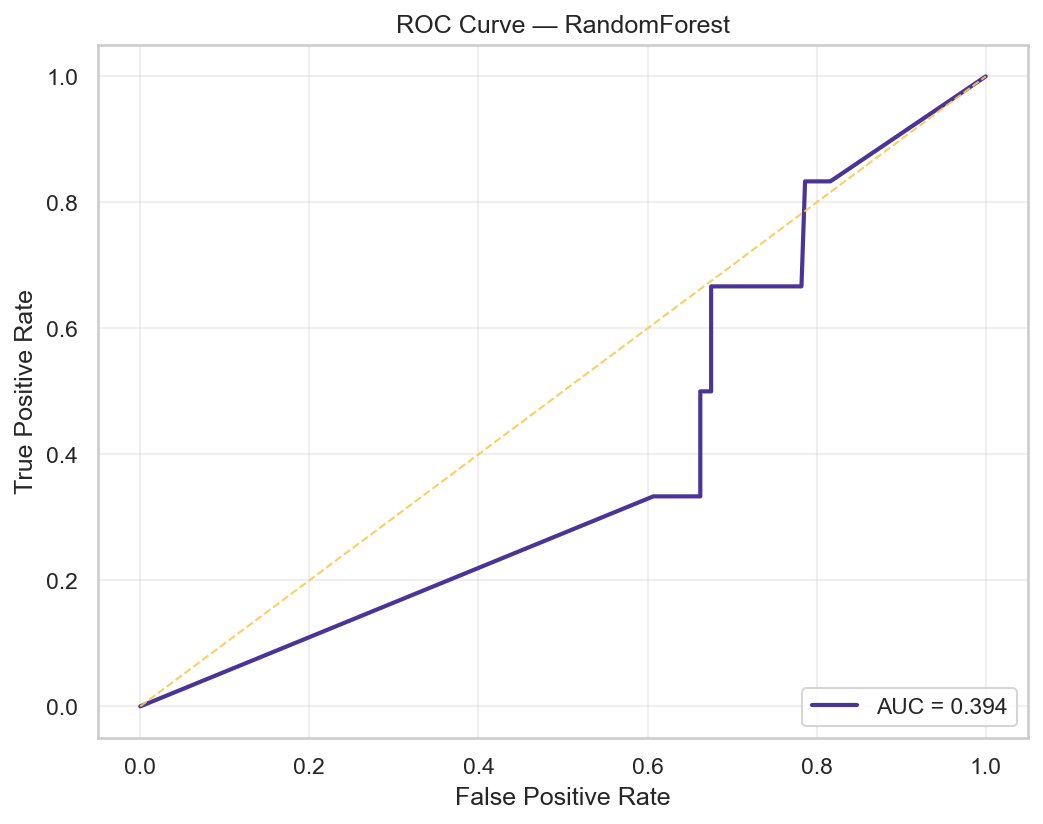

Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/rf_pr.png


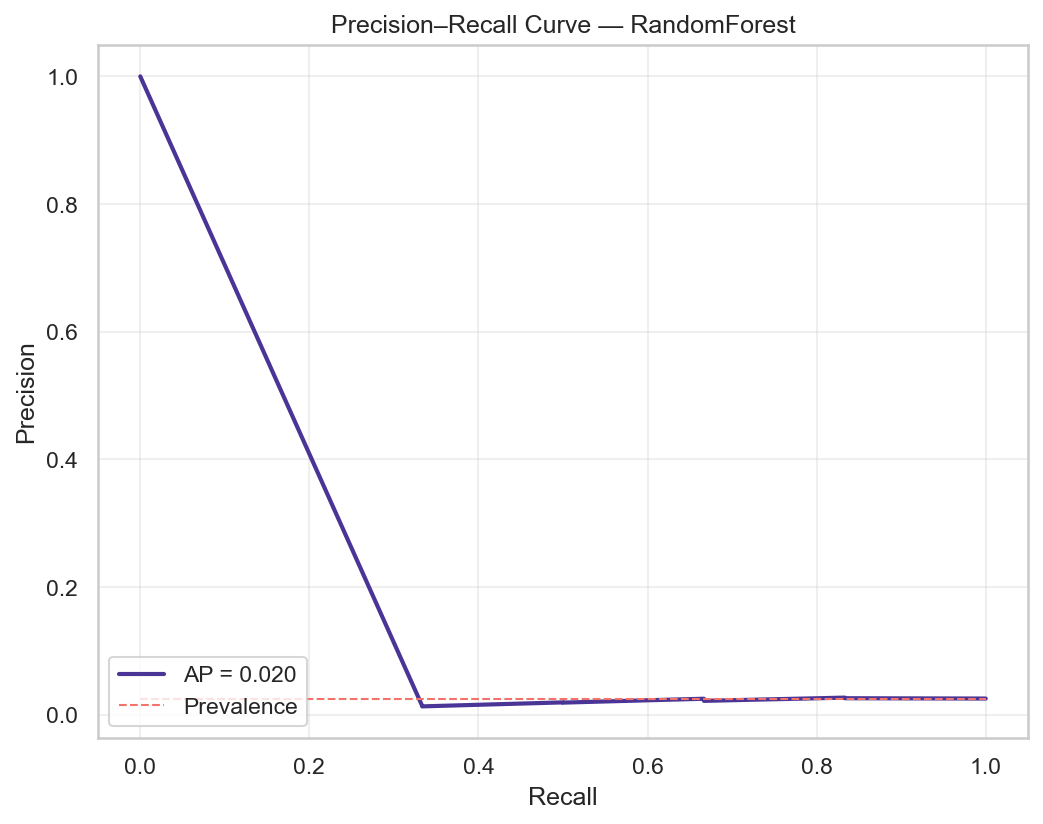

RandomForest CV — ROC AUC: 0.568 ± 0.096 | PR AUC: 0.035 ± 0.058


,fold,roc_auc,pr_auc
0,1,NaN,0.000
1,2,NaN,0.000
2,3,0.500,0.042
3,4,0.636,0.134
4,5,NaN,0.000


Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/rf_top25.csv
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/rf_top25.png


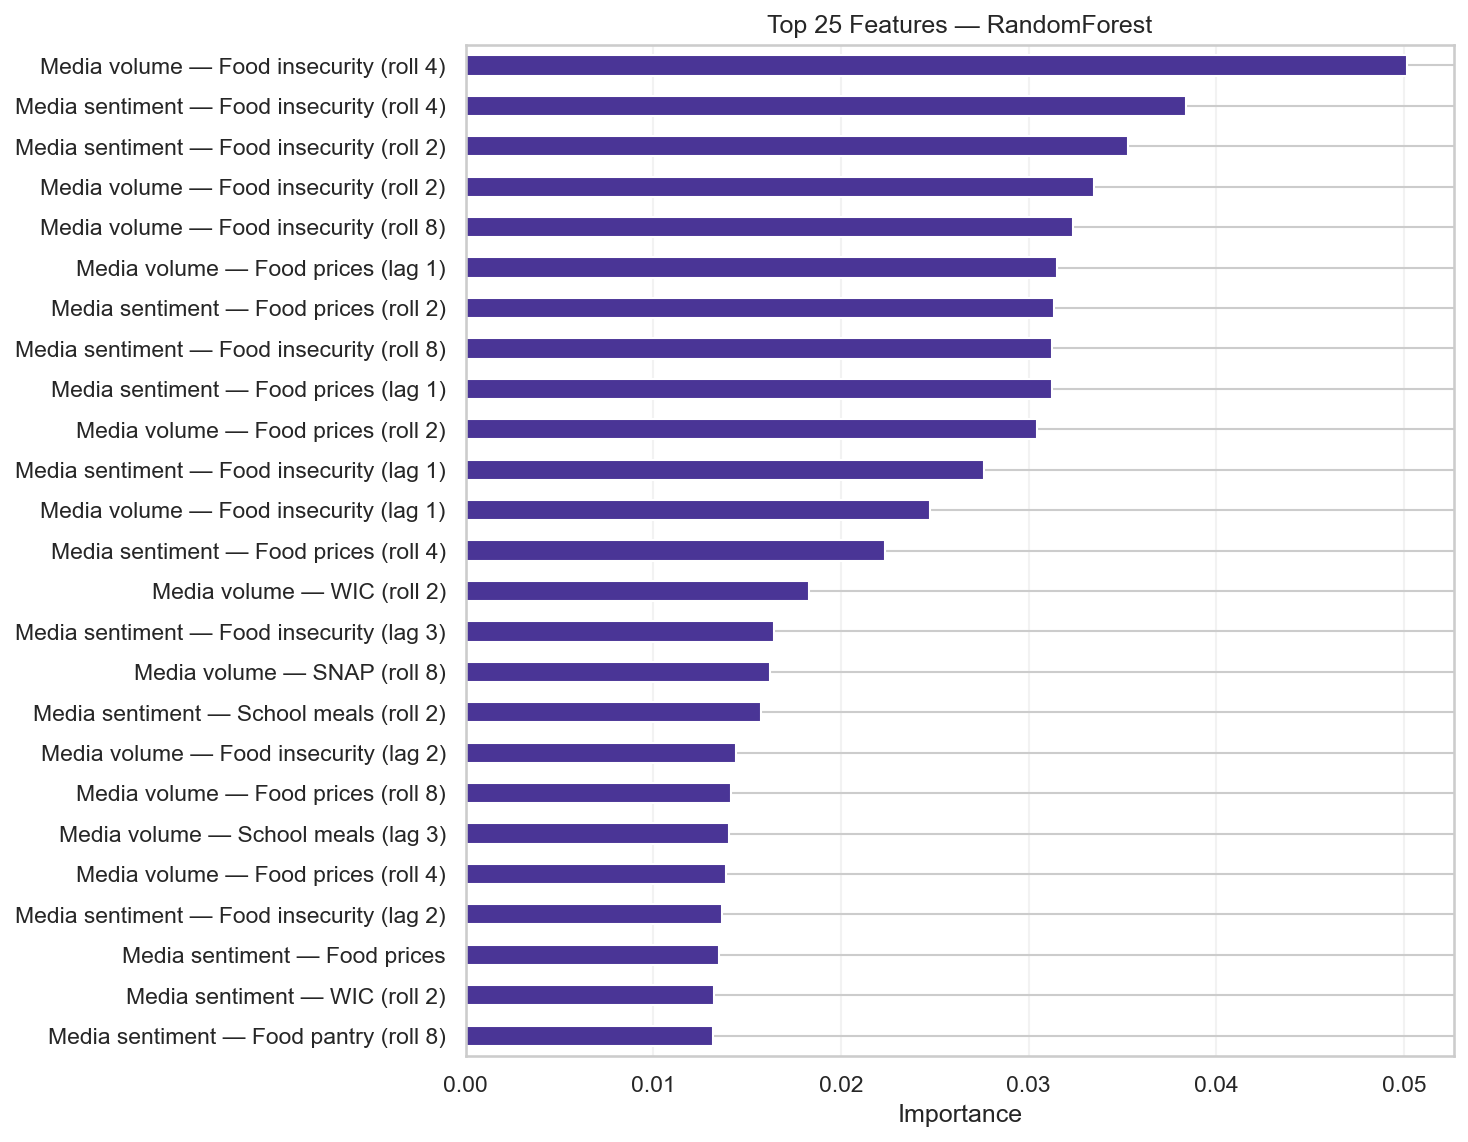

Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/rf_shap_meanabs.csv
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/rf_shap_bar.png
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/rf_shap_swarm.png
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/rf_shap_bar_norm.png
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My

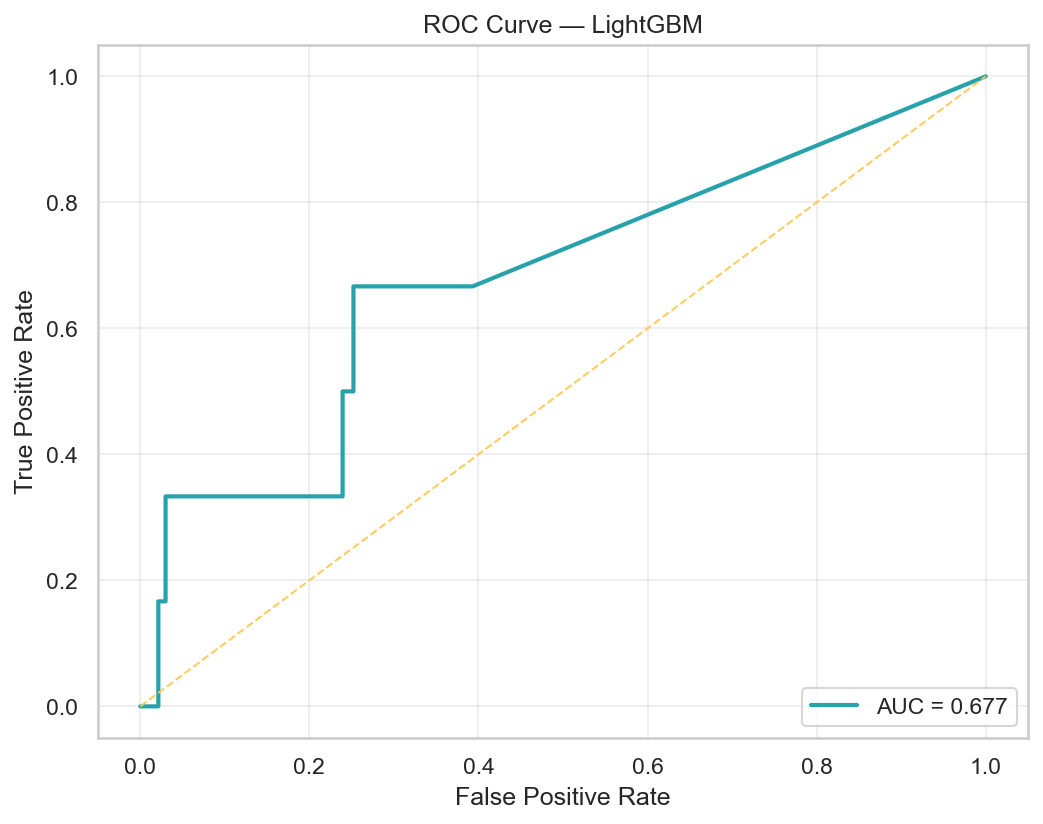

Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/lgbm_pr.png


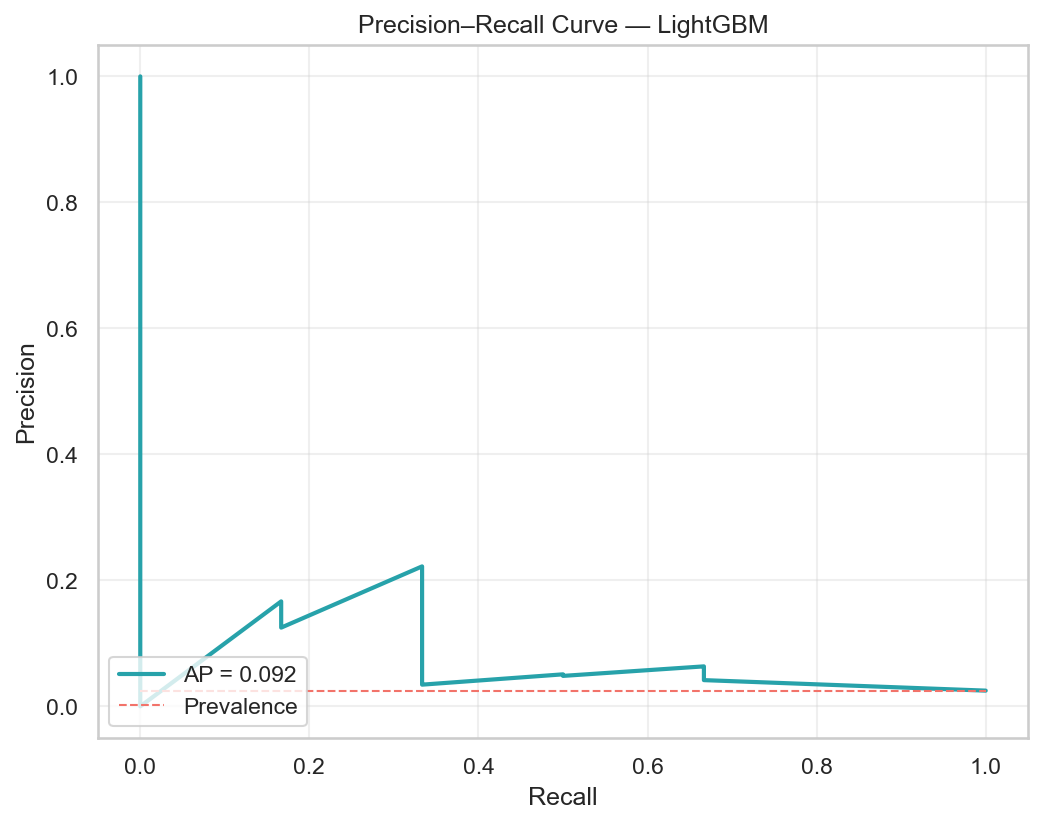

LightGBM CV — ROC AUC: 0.480 ± 0.028 | PR AUC: 0.040 ± 0.069


,fold,roc_auc,pr_auc
0,1,NaN,0.000
1,2,NaN,0.000
2,3,0.50,0.042
3,4,0.46,0.159
4,5,NaN,0.000


Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/lgbm_top25.csv
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/lgbm_top25.png


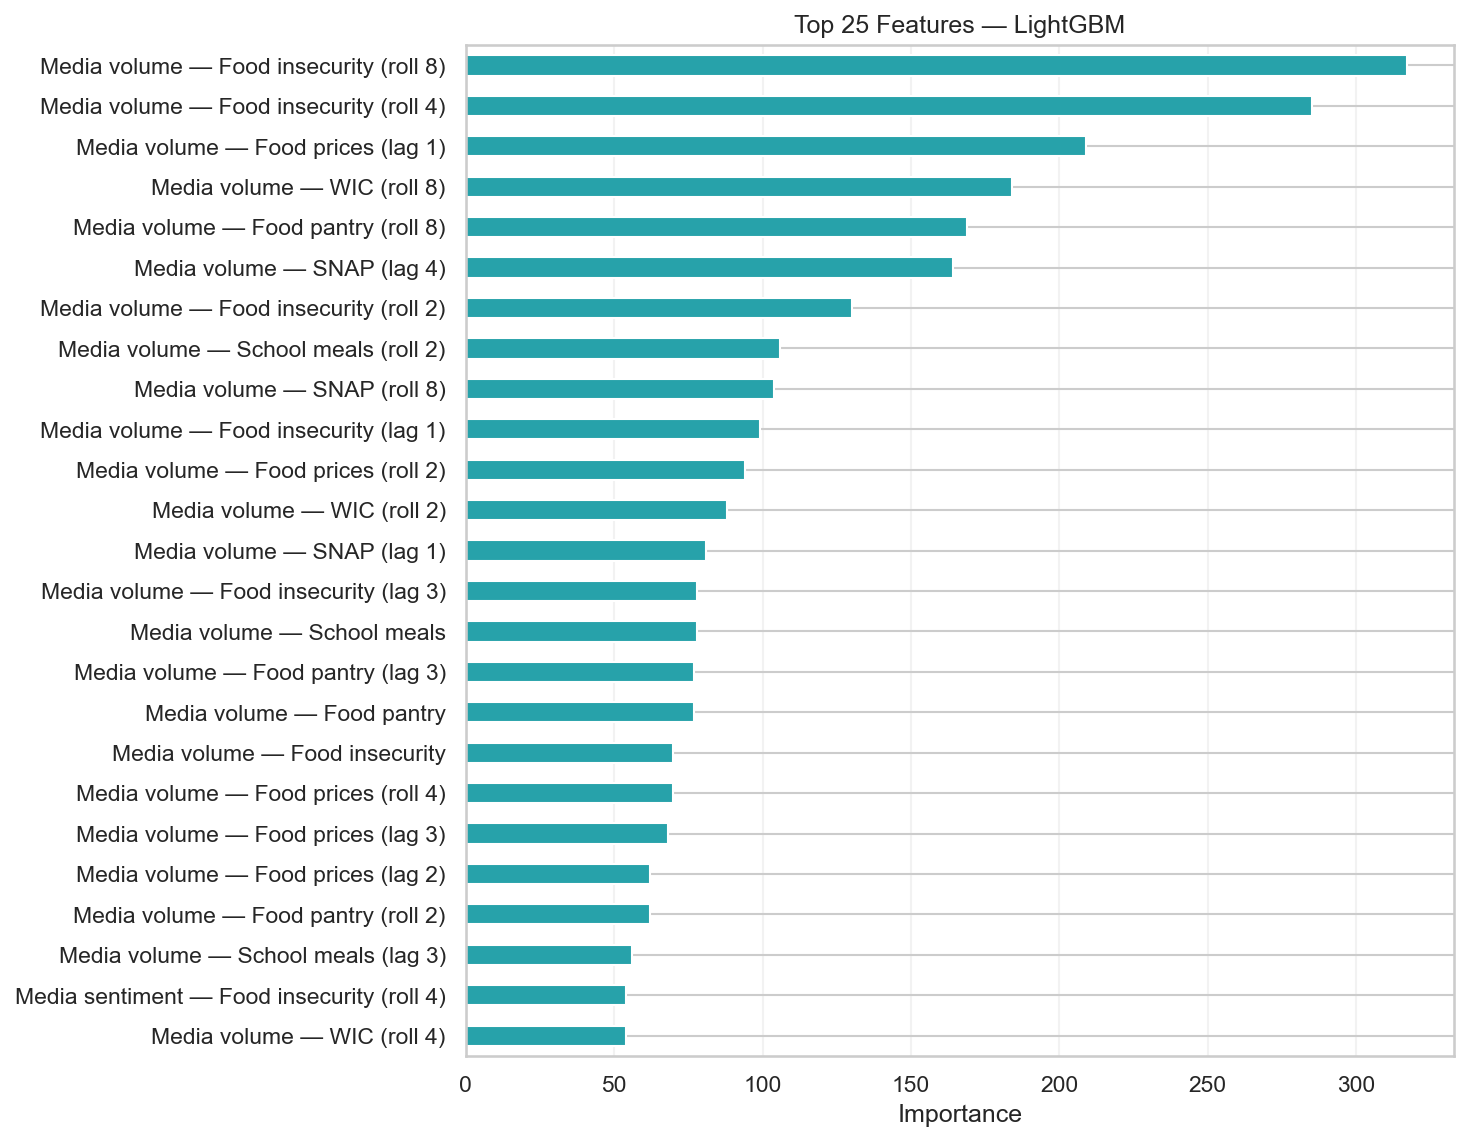

Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/lgbm_shap_meanabs.csv
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/lgbm_shap_bar.png
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/lgbm_shap_swarm.png


In [12]:
# Modeling
# Random Forest 
rf_oof, rf_folds = ts_cv_predict(
    lambda: RandomForestClassifier(
        n_estimators=600, max_depth=None, min_samples_leaf=2,
        random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced"
    ),
    X_model, y, n_splits=N_SPLITS, quiet=True
)

# curves (saved as short filenames + displayed)
evaluate_and_plot_short(y.loc[rf_oof.index], rf_oof, model_label="RandomForest", outdir=OUTPUT_DIR)
summarize_cv(rf_folds, "RandomForest")

# final fit on all data for explainability
rf_final = RandomForestClassifier(
    n_estimators=800, random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced"
)
rf_final.fit(X_model, y)

# feature importance (pretty labels + CSV + PNG)
plot_feature_importance_pretty(
    rf_final, X_model, model_label="RandomForest",
    outdir=OUTPUT_DIR, top_n=25, reverse_map=rev_map
)

# SHAP (bar + beeswarm + CSV). sample_n speeds up beeswarm if big
plot_shap_pretty(
    rf_final, X_model, model_label="RandomForest",
    outdir=OUTPUT_DIR, max_display=25, reverse_map=rev_map, sample_n=2000
)


# LightGBM
if HAS_LGBM:
    def make_lgb():
        return lgb.LGBMClassifier(
            n_estimators=800,
            learning_rate=0.03,
            num_leaves=63,
            colsample_bytree=0.8,
            subsample=0.8,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1, verbosity=-1
        )

    lgb_oof, lgb_folds = ts_cv_predict(
        make_lgb, X_model, y, n_splits=N_SPLITS, quiet=True, lgb_eval_period=0
    )

    # curves
    evaluate_and_plot_short(y.loc[lgb_oof.index], lgb_oof, model_label="LightGBM", outdir=OUTPUT_DIR)
    summarize_cv(lgb_folds, "LightGBM")

    # final fit + explainability
    lgb_final = make_lgb()
    lgb_final.fit(X_model, y)

    plot_feature_importance_pretty(
        lgb_final, X_model, model_label="LightGBM",
        outdir=OUTPUT_DIR, top_n=25, reverse_map=rev_map
    )
    plot_shap_pretty(
        lgb_final, X_model, model_label="LightGBM",
        outdir=OUTPUT_DIR, max_display=25, reverse_map=rev_map, sample_n=2000
    )
else:
    print("LightGBM not installed — skipped.")

## 9) Explainability — Feature Importance and SHAP

Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/rf_top25.csv
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/rf_top25.png


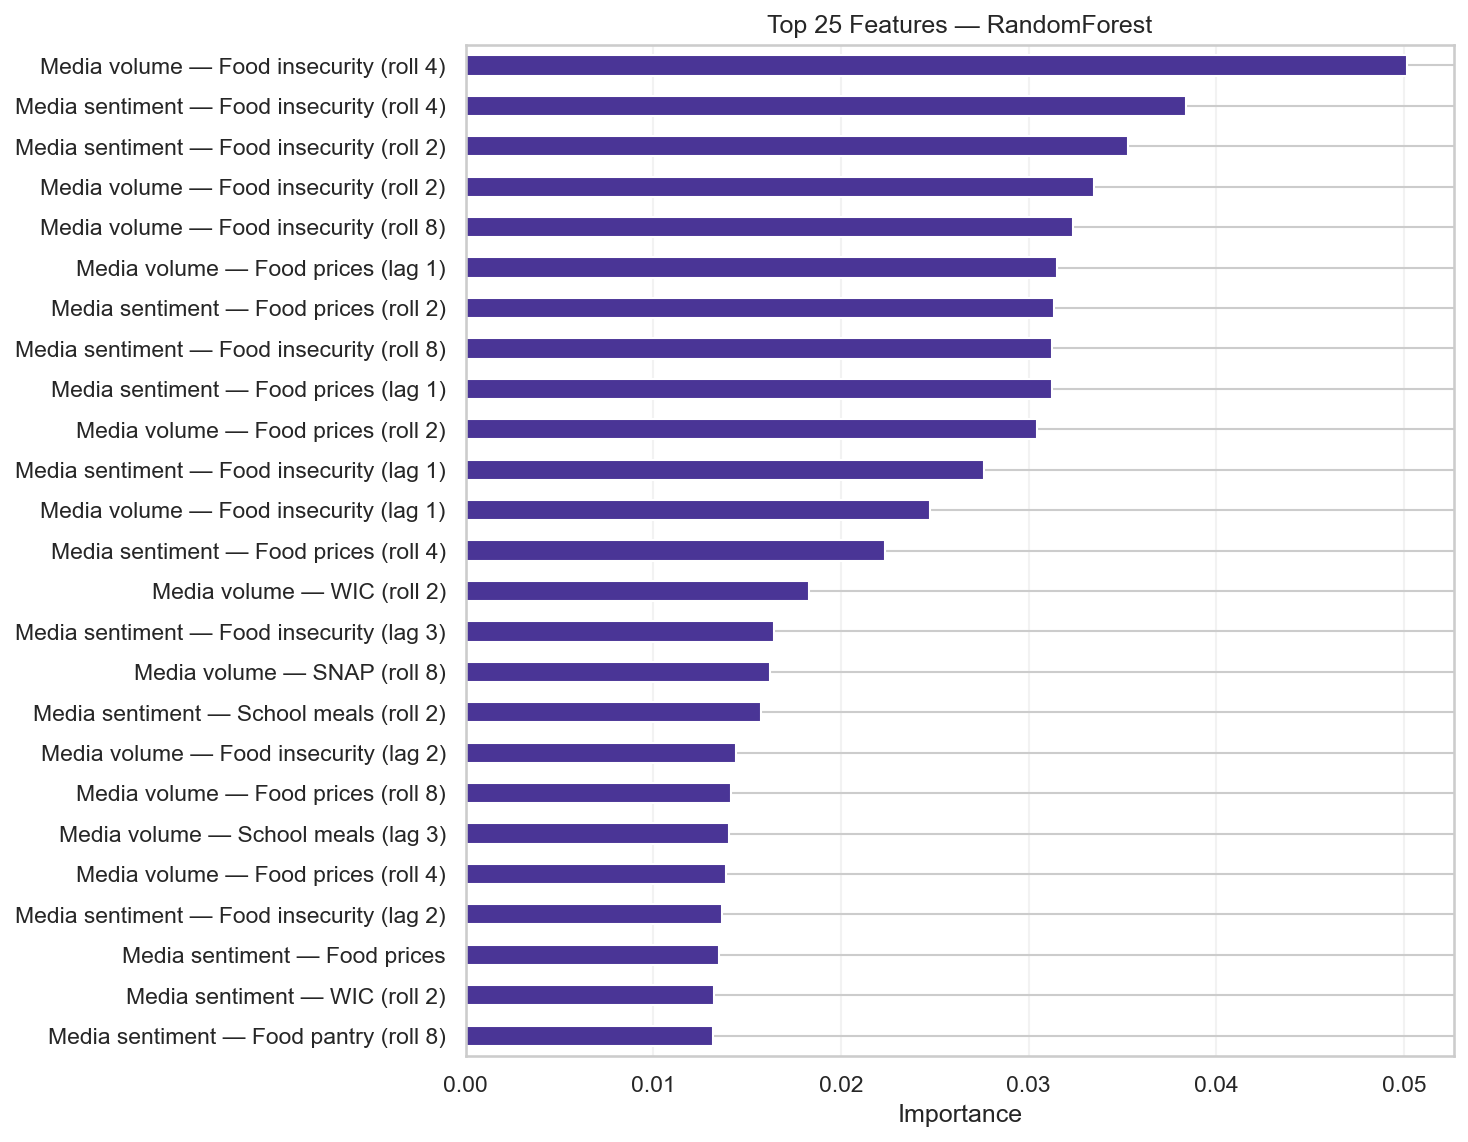

Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/rf_shap_meanabs.csv
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/rf_shap_bar.png
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/rf_shap_swarm.png
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/rf_shap_bar_norm.png
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My

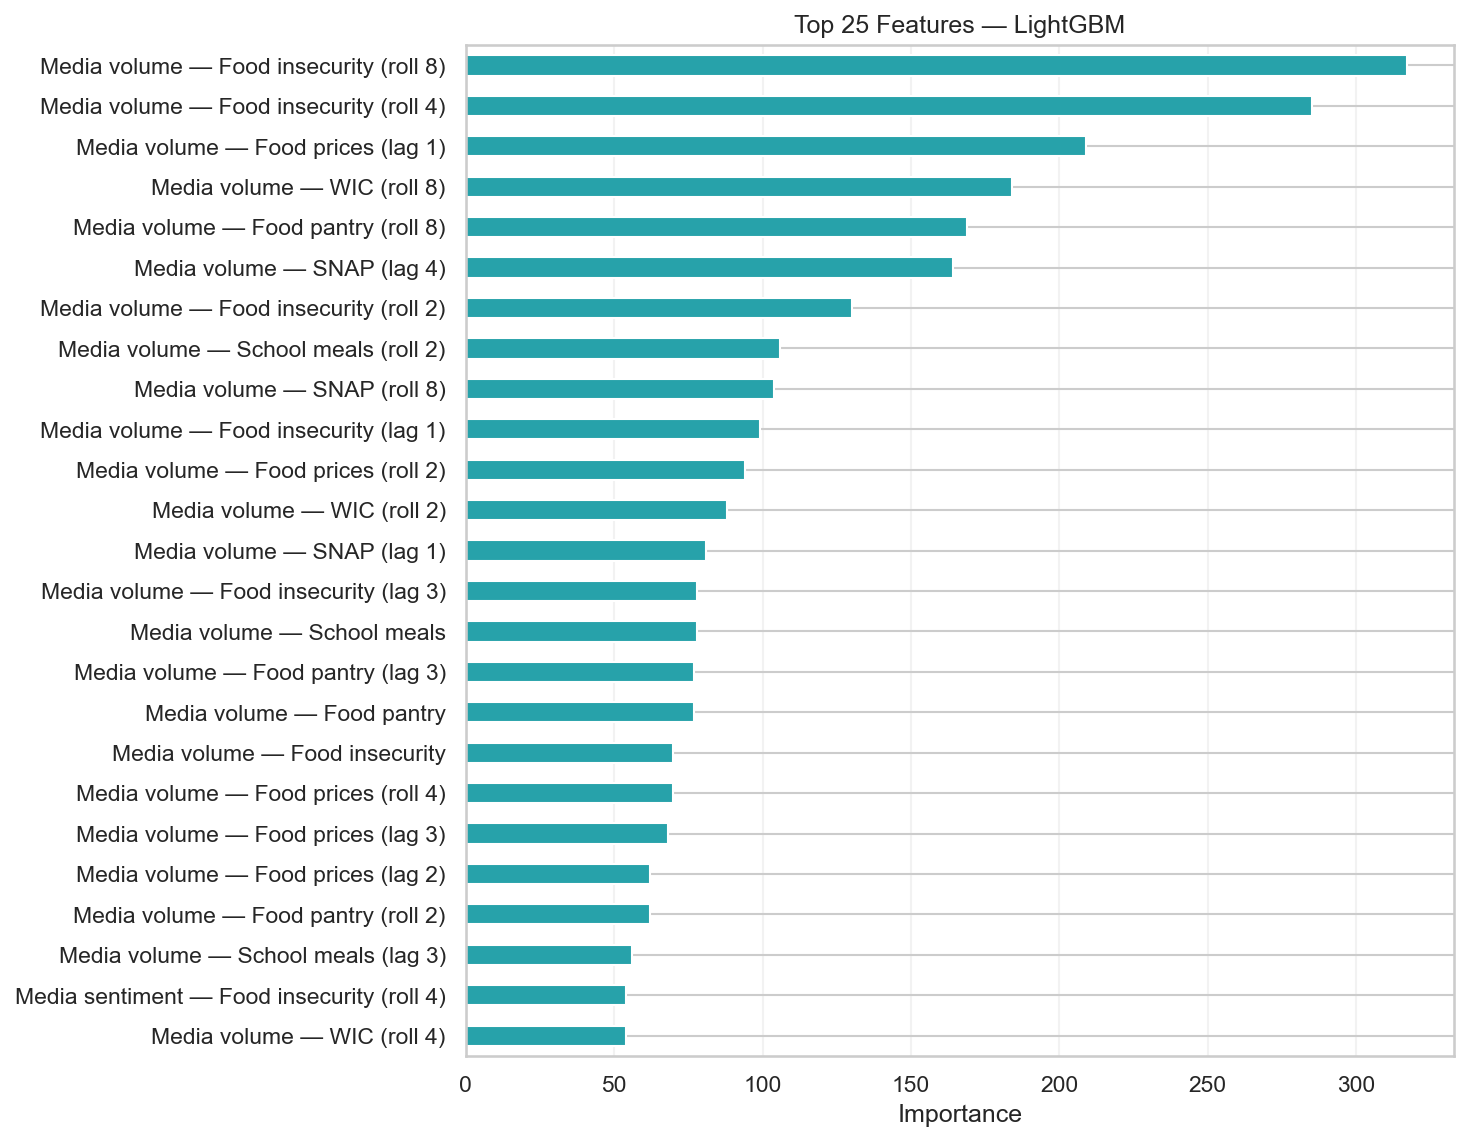

Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/lgbm_shap_meanabs.csv
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/lgbm_shap_bar.png
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/lgbm_shap_swarm.png


In [13]:
# Fit final RF on all data (reuse sanitized X_model to avoid LightGBM name errors)
rf_final = RandomForestClassifier(
    n_estimators=800, random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced"
)
rf_final.fit(X_model, y)

# Export + display feature importance plot
rf_imp_path = plot_feature_importance_pretty(
    rf_final, X_model, model_label="RandomForest",
    outdir=OUTPUT_DIR, top_n=25, reverse_map=rev_map
)

# Export + display SHAP plots
rf_shap_paths = plot_shap_pretty(
    rf_final, X_model, model_label="RandomForest",
    outdir=OUTPUT_DIR, max_display=25, reverse_map=rev_map, sample_n=2000
)

# LightGBM final model (if installed)
if HAS_LGBM:
    lgb_final = make_lgb()
    lgb_final.fit(X_model, y)

    lgb_imp_path = plot_feature_importance_pretty(
        lgb_final, X_model, model_label="LightGBM",
        outdir=OUTPUT_DIR, top_n=25, reverse_map=rev_map
    )
    lgb_shap_paths = plot_shap_pretty(
        lgb_final, X_model, model_label="LightGBM",
        outdir=OUTPUT_DIR, max_display=25, reverse_map=rev_map, sample_n=2000
    )
else:
    print("LightGBM not installed — skipped.")


Loaded RF importance: True
Loaded LGBM importance: True
Loaded RF SHAP: True
Loaded LGBM SHAP: True

=== Feature Importance Comparison ===
RF importance columns: ['feature_pretty', 'feature_internal', 'importance']
LGBM importance columns: ['feature_pretty', 'feature_internal', 'importance']
Using RF column: importance
Using LGBM column: importance
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/compare_importance_rf_vs_lgbm.png


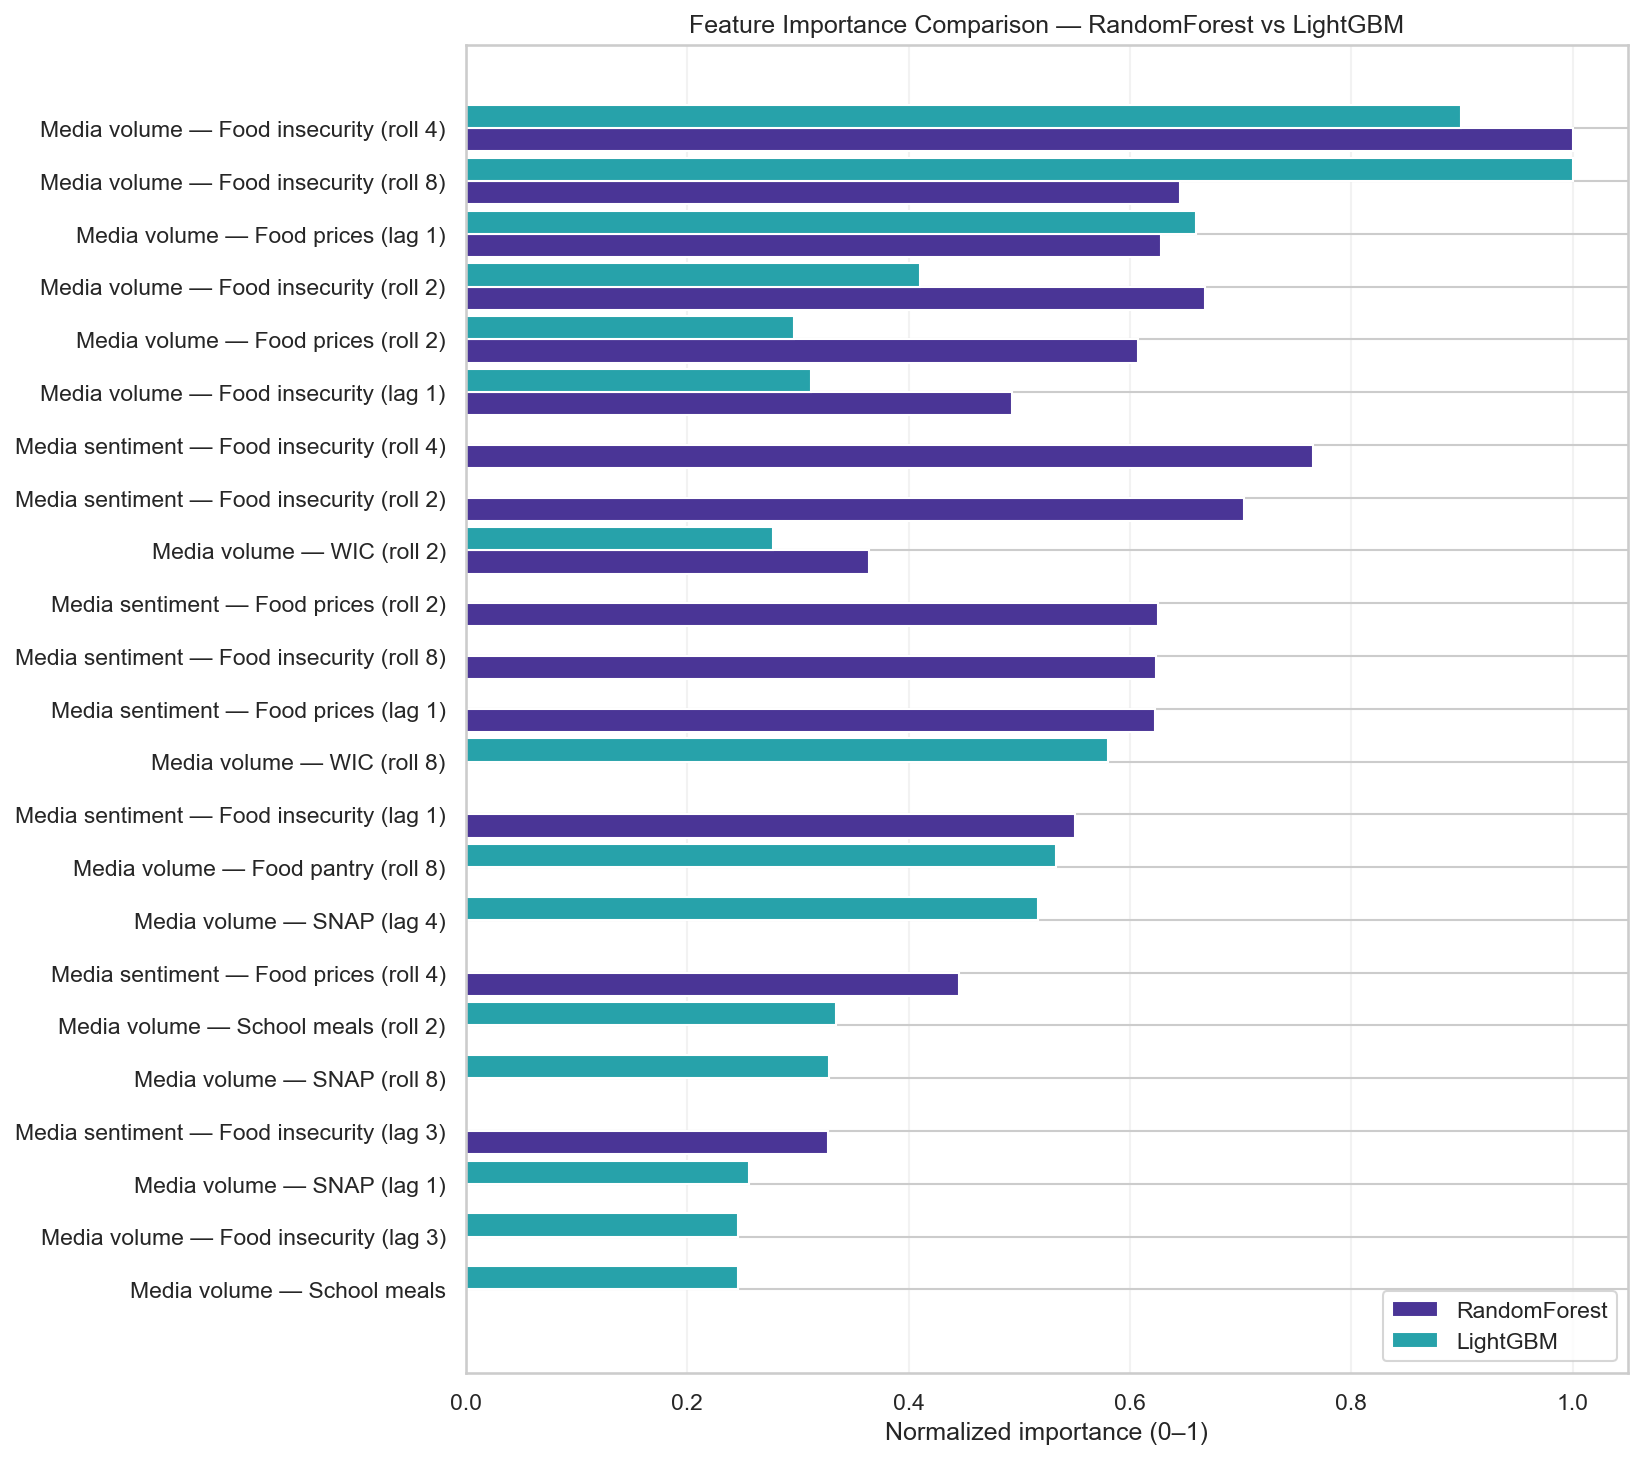

Saved comparison data: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/compare_importance_union.csv

Top 5 features by importance:


,feature_pretty,RandomForest_value,LightGBM_value
19,Media volume — School meals,NaN,78.0
9,Media volume — Food insecurity (lag 3),NaN,78.0
16,Media volume — SNAP (lag 1),NaN,81.0
1,Media sentiment — Food insecurity (lag 3),0.016407,NaN
18,Media volume — SNAP (roll 8),NaN,104.0



=== SHAP Value Comparison ===
RF SHAP columns: ['feature_pretty', 'feature_internal', 'mean_abs_shap']
LGBM SHAP columns: ['feature_pretty', 'feature_internal', 'mean_abs_shap']
Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/compare_shap_rf_vs_lgbm.png


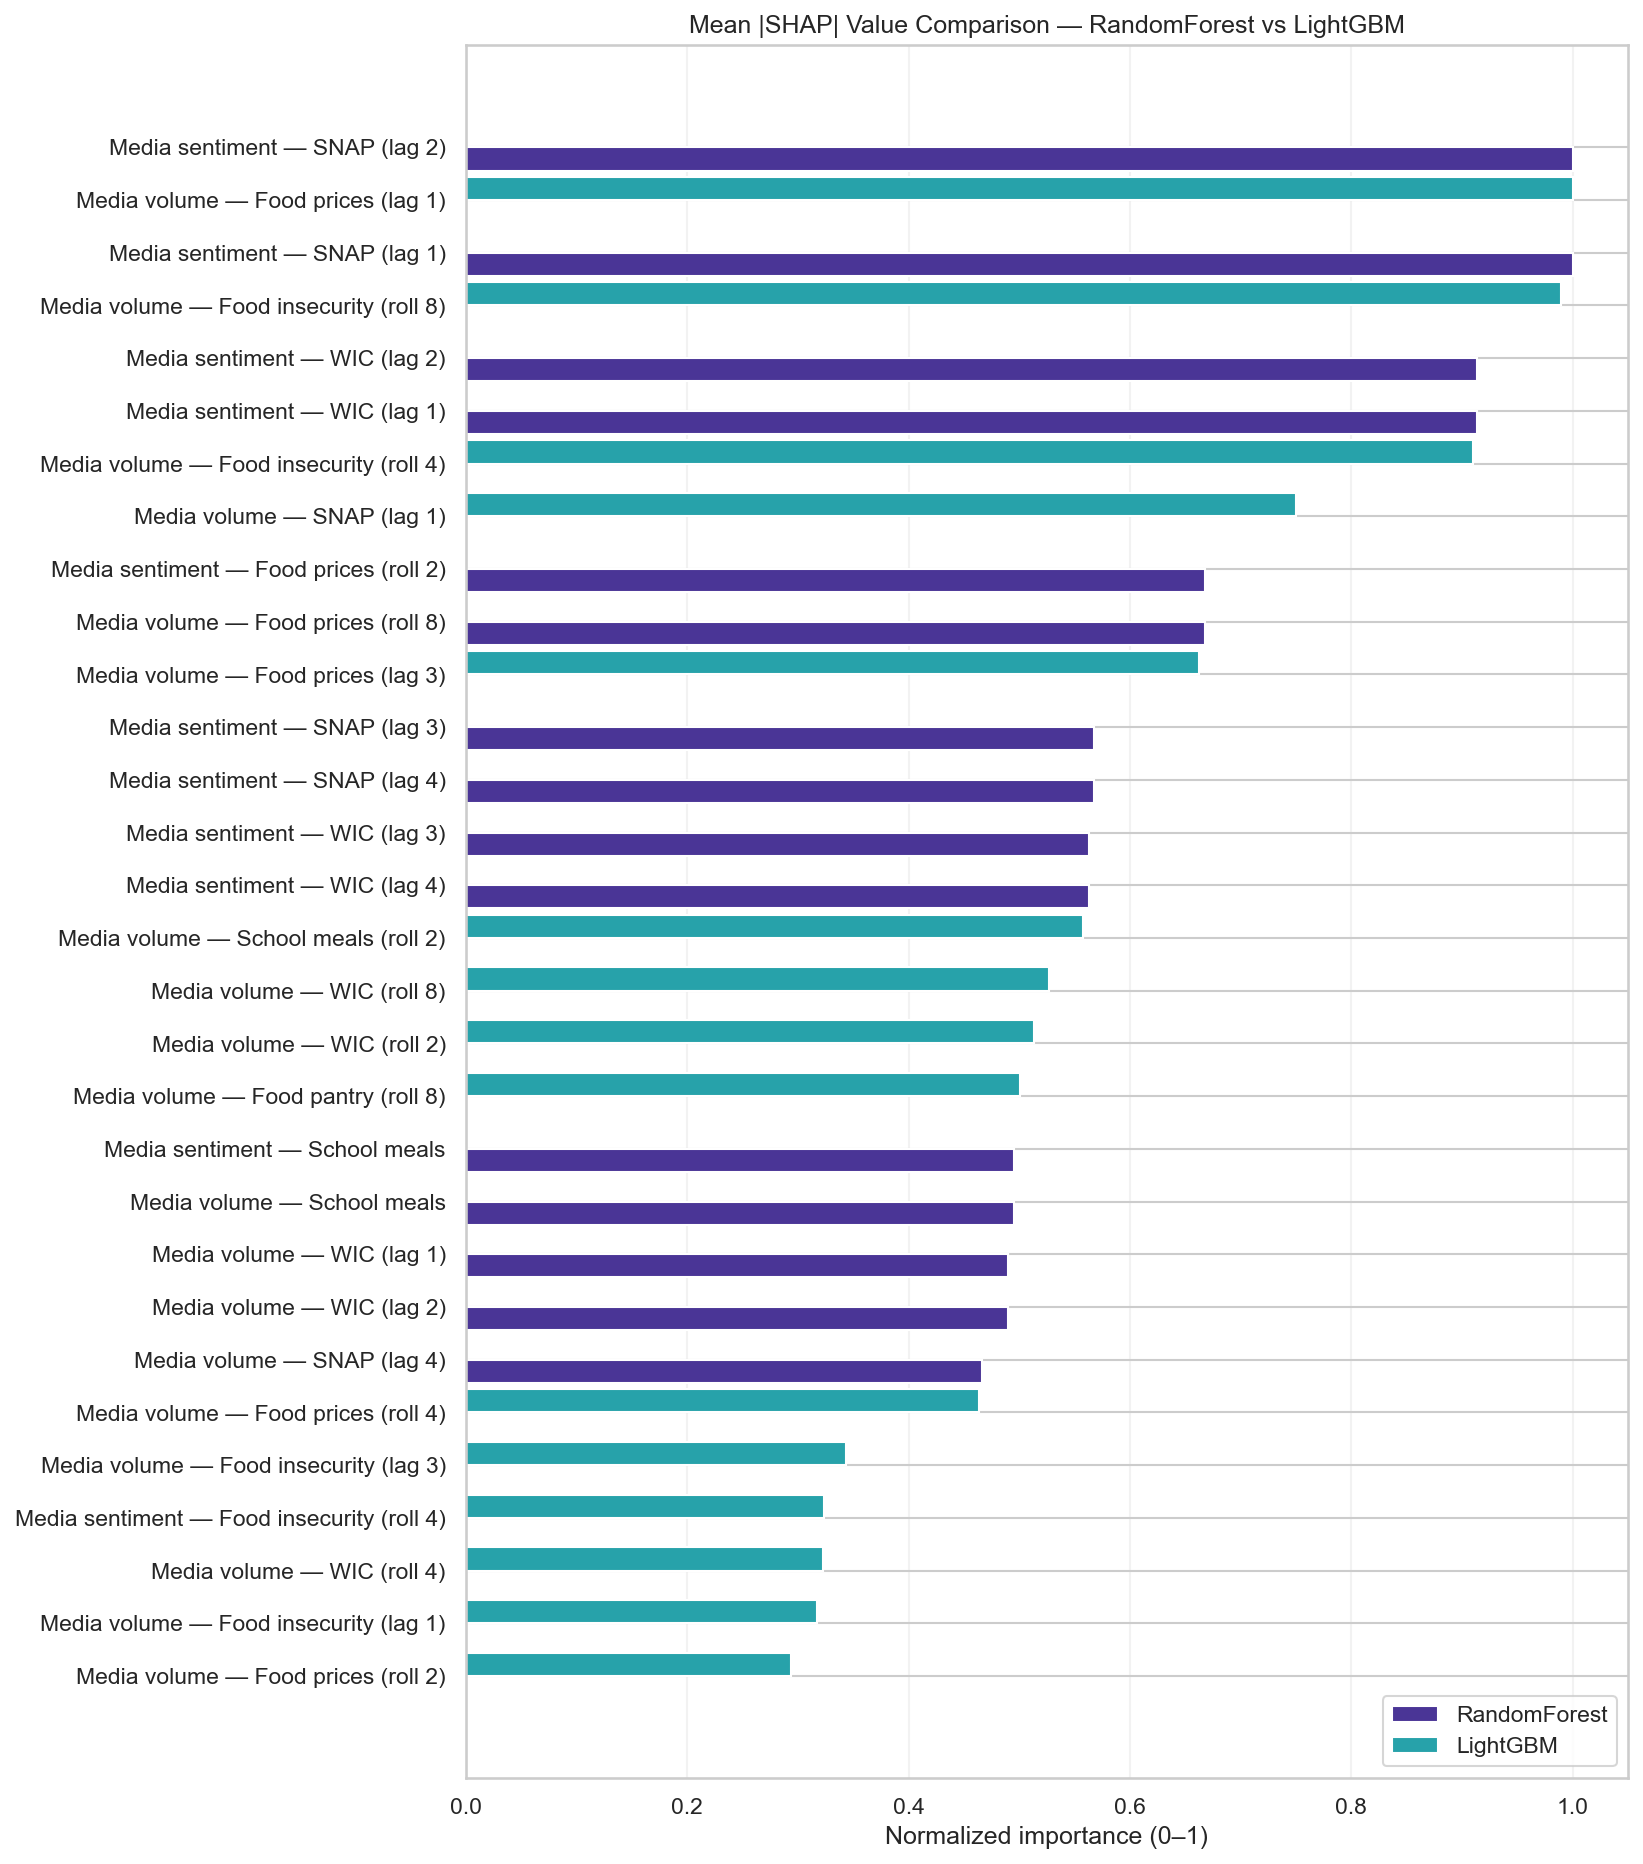

Saved SHAP comparison data: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/compare_shap_union.csv

Top 5 features by mean |SHAP|:


,feature_pretty,RandomForest_value,LightGBM_value
18,Media volume — Food prices (roll 2),NaN,0.160402
11,Media volume — Food insecurity (lag 1),NaN,0.173124
28,Media volume — WIC (roll 4),NaN,0.175934
0,Media sentiment — Food insecurity (roll 4),NaN,0.176590
12,Media volume — Food insecurity (lag 3),NaN,0.187560



=== Summary Statistics ===

Features in top 10 for both models (4):
  • Media volume — Food insecurity (roll 2)
  • Media volume — Food insecurity (roll 4)
  • Media volume — Food insecurity (roll 8)
  • Media volume — Food prices (lag 1)

Unique to RF top 10 (6):
  • Media sentiment — Food insecurity (roll 2)
  • Media sentiment — Food insecurity (roll 4)
  • Media sentiment — Food insecurity (roll 8)
  • Media sentiment — Food prices (lag 1)
  • Media sentiment — Food prices (roll 2)
  • Media volume — Food prices (roll 2)

Unique to LightGBM top 10 (6):
  • Media volume — Food insecurity (lag 1)
  • Media volume — Food pantry (roll 8)
  • Media volume — SNAP (lag 4)
  • Media volume — SNAP (roll 8)
  • Media volume — School meals (roll 2)
  • Media volume — WIC (roll 8)

✅ Comparison analysis complete!


In [14]:
# ==========================================
# COMPARISON PLOTS
# ==========================================

def plot_compare_bars(
    df_left, df_right,
    left_value_col, right_value_col,
    label_col="feature_pretty",
    left_name="RandomForest",
    right_name="LightGBM",
    top_k=15,
    title="",
    outfile=None
):
    import numpy as np

    c_left  = RF_COLOR
    c_right = LGBM_COLOR

    L = (
        df_left[[label_col, left_value_col]]
        .drop_duplicates(subset=[label_col])
        .rename(columns={left_value_col: "left_value"})
    )
    R = (
        df_right[[label_col, right_value_col]]
        .drop_duplicates(subset=[label_col])
        .rename(columns={right_value_col: "right_value"})
    )

    L["rank_left"]  = L["left_value"].rank(ascending=False, method="min")
    R["rank_right"] = R["right_value"].rank(ascending=False, method="min")

    topL = L.nsmallest(top_k, "rank_left")
    topR = R.nsmallest(top_k, "rank_right")
    union = pd.merge(topL, topR, on=label_col, how="outer")

    def _norm(s):
        s = pd.to_numeric(s, errors="coerce").fillna(0.0)
        m = s.max()
        return s / m if (m and np.isfinite(m) and m != 0) else s

    union[f"{left_name}_norm"]  = _norm(union["left_value"])
    union[f"{right_name}_norm"] = _norm(union["right_value"])
    union["avg_norm"] = (union[f"{left_name}_norm"] + union[f"{right_name}_norm"]) / 2.0
    union = union.sort_values("avg_norm", ascending=True)

    # >>> NEW: give the raw values model-specific names too
    union = union.rename(columns={
        "left_value":  f"{left_name}_value",
        "right_value": f"{right_name}_value",
    })

    # Plot
    labels = union[label_col].tolist()
    y = np.arange(len(labels)); h = 0.44
    fig, ax = plt.subplots(figsize=(10, max(4, 0.5*len(labels))))
    ax.barh(y - h/2, union[f"{left_name}_norm"],  height=h, label=left_name,  color=c_left)
    ax.barh(y + h/2, union[f"{right_name}_norm"], height=h, label=right_name, color=c_right)
    ax.set_yticks(y); ax.set_yticklabels(labels)
    ax.set_xlabel("Normalized importance (0–1)")
    ax.set_title(title or f"{left_name} vs {right_name} — Top features (union, normalized)")
    ax.legend(loc="lower right"); ax.grid(True, axis="x", alpha=0.25)

    if outfile:
        save_and_show(fig, outfile)
    else:
        plt.show()

    return union


# ==========================================
# LOAD AND COMPARE RESULTS
# ==========================================

# Load the dataframes (using load_df without underscore)
rf_imp_df = load_df(globals().get("rf_top25"), os.path.join(OUTPUT_DIR, "rf_top25.csv"))
lgbm_imp_df = load_df(globals().get("lgbm_top25"), os.path.join(OUTPUT_DIR, "lgbm_top25.csv"))
rf_shap_df = load_df(globals().get("rf_shap"), os.path.join(OUTPUT_DIR, "rf_shap_meanabs.csv"))
lgbm_shap_df = load_df(globals().get("lgbm_shap"), os.path.join(OUTPUT_DIR, "lgbm_shap_meanabs.csv"))

# Check if files were loaded successfully
print(f"Loaded RF importance: {not rf_imp_df.empty}")
print(f"Loaded LGBM importance: {not lgbm_imp_df.empty}")
print(f"Loaded RF SHAP: {not rf_shap_df.empty}")
print(f"Loaded LGBM SHAP: {not lgbm_shap_df.empty}")

# ==========================================
# FEATURE IMPORTANCE COMPARISON
# ==========================================

if not rf_imp_df.empty and not lgbm_imp_df.empty:
    print("\n=== Feature Importance Comparison ===")
    print("RF importance columns:", rf_imp_df.columns.tolist())
    print("LGBM importance columns:", lgbm_imp_df.columns.tolist())
    
    # Use detect_importance_col from helpers (without underscore)
    rf_imp_col = detect_importance_col(rf_imp_df)
    lgbm_imp_col = detect_importance_col(lgbm_imp_df)
    
    print(f"Using RF column: {rf_imp_col}")
    print(f"Using LGBM column: {lgbm_imp_col}")
    
    # Create comparison plot
    imp_out = os.path.join(OUTPUT_DIR, "compare_importance_rf_vs_lgbm.png")
    imp_union = plot_compare_bars(
        df_left=rf_imp_df, 
        df_right=lgbm_imp_df,
        left_value_col=rf_imp_col,
        right_value_col=lgbm_imp_col,
        label_col="feature_pretty",
        left_name="RandomForest",
        right_name="LightGBM",
        top_k=15,
        title="Feature Importance Comparison — RandomForest vs LightGBM",
        outfile=imp_out
    )
    
    # Save comparison data
    imp_union.to_csv(os.path.join(OUTPUT_DIR, "compare_importance_union.csv"), index=False)
    print(f"Saved comparison data: {os.path.join(OUTPUT_DIR, 'compare_importance_union.csv')}")
    
    # Show top features from each model
    print("\nTop 5 features by importance:")
    display(imp_union[["feature_pretty", "RandomForest_value", "LightGBM_value"]].head())
else:
    print("⚠️ Missing importance data for comparison")

# ==========================================
# SHAP VALUE COMPARISON
# ==========================================

if not rf_shap_df.empty and not lgbm_shap_df.empty:
    print("\n=== SHAP Value Comparison ===")
    print("RF SHAP columns:", rf_shap_df.columns.tolist())
    print("LGBM SHAP columns:", lgbm_shap_df.columns.tolist())
    
    # Create SHAP comparison plot
    shap_out = os.path.join(OUTPUT_DIR, "compare_shap_rf_vs_lgbm.png")
    shap_union = plot_compare_bars(
        df_left=rf_shap_df, 
        df_right=lgbm_shap_df,
        left_value_col="mean_abs_shap",
        right_value_col="mean_abs_shap",
        label_col="feature_pretty",
        left_name="RandomForest",
        right_name="LightGBM",
        top_k=15,
        title="Mean |SHAP| Value Comparison — RandomForest vs LightGBM",
        outfile=shap_out
    )
    
    # Save SHAP comparison data
    shap_union.to_csv(os.path.join(OUTPUT_DIR, "compare_shap_union.csv"), index=False)
    print(f"Saved SHAP comparison data: {os.path.join(OUTPUT_DIR, 'compare_shap_union.csv')}")
    
    # Show top features by SHAP
    print("\nTop 5 features by mean |SHAP|:")
    # Fix: Use the correct column names with _value suffix
    display(shap_union[["feature_pretty", "RandomForest_value", "LightGBM_value"]].head())
else:
    print("⚠️ Missing SHAP data for comparison")

# ==========================================
# SUMMARY STATISTICS
# ==========================================

print("\n=== Summary Statistics ===")

if not rf_imp_df.empty and not lgbm_imp_df.empty:
    # Find features that appear in top 10 for both models
    rf_top10 = set(rf_imp_df.nlargest(10, rf_imp_col)["feature_pretty"])
    lgbm_top10 = set(lgbm_imp_df.nlargest(10, lgbm_imp_col)["feature_pretty"])
    
    common_features = rf_top10.intersection(lgbm_top10)
    print(f"\nFeatures in top 10 for both models ({len(common_features)}):")
    for feat in sorted(common_features):
        print(f"  • {feat}")
    
    rf_only = rf_top10 - lgbm_top10
    if rf_only:
        print(f"\nUnique to RF top 10 ({len(rf_only)}):")
        for feat in sorted(rf_only):
            print(f"  • {feat}")
    
    lgbm_only = lgbm_top10 - rf_top10
    if lgbm_only:
        print(f"\nUnique to LightGBM top 10 ({len(lgbm_only)}):")
        for feat in sorted(lgbm_only):
            print(f"  • {feat}")

print("\n✅ Comparison analysis complete!")

## 10) Save Outputs

In [15]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Use the modeling matrix index for alignment
idx = X_model.index

# Build arrays aligned to idx (avoid carrying index names)
date_arr = pd.Index(idx).to_numpy()

y_arr = pd.Series(y, index=idx).reindex(idx).to_numpy()

rf_arr = None
if "rf_oof" in globals() and rf_oof is not None:
    rf_arr = pd.Series(rf_oof, index=rf_oof.index).reindex(idx).to_numpy()

lgb_arr = None
if "lgb_oof" in globals() and lgb_oof is not None:
    lgb_arr = pd.Series(lgb_oof, index=lgb_oof.index).reindex(idx).to_numpy()

# Assemble dict (only include available columns)
pred_cols = {"date": date_arr, "y_true": y_arr}
if rf_arr is not None:
    pred_cols["rf_score"] = rf_arr
if lgb_arr is not None:
    pred_cols["lgbm_score"] = lgb_arr

preds = pd.DataFrame(pred_cols).sort_values("date").dropna(how="any")  # no index/column name clash now

# Paths
preds_path    = os.path.join(OUTPUT_DIR, f"predictions_{FREQ}.csv")
features_path = os.path.join(OUTPUT_DIR, f"features_{FREQ}.csv")
name_map_path = os.path.join(OUTPUT_DIR, "feature_name_map.csv")
metrics_path  = os.path.join(OUTPUT_DIR, "cv_metrics_summary.csv")

# Save predictions
preds.to_csv(preds_path, index=False)

# Save features (sanitized headers you modeled with). Preserve time index with a clear label.
X_model.to_csv(features_path, index=True, index_label="date")

# Save name map (sanitized -> original)
if "name_map" in globals() and isinstance(name_map, dict):
    pd.DataFrame([{"sanitized": k, "original": v} for k, v in name_map.items()]).to_csv(name_map_path, index=False)

# Save concise CV metrics summary (if available)
rows = []
if "rf_folds" in globals() and isinstance(rf_folds, pd.DataFrame):
    rows.append({
        "model": "RandomForest",
        "roc_auc_mean": rf_folds["roc_auc"].mean(),
        "roc_auc_std":  rf_folds["roc_auc"].std(ddof=1),
        "pr_auc_mean":  rf_folds["pr_auc"].mean(),
        "pr_auc_std":   rf_folds["pr_auc"].std(ddof=1),
        "n_folds":      len(rf_folds)
    })
if "lgb_folds" in globals() and isinstance(lgb_folds, pd.DataFrame):
    rows.append({
        "model": "LightGBM",
        "roc_auc_mean": lgb_folds["roc_auc"].mean(),
        "roc_auc_std":  lgb_folds["roc_auc"].std(ddof=1),
        "pr_auc_mean":  lgb_folds["pr_auc"].mean(),
        "pr_auc_std":   lgb_folds["pr_auc"].std(ddof=1),
        "n_folds":      len(lgb_folds)
    })
if rows:
    pd.DataFrame(rows).to_csv(metrics_path, index=False)

print("Saved:")
print(" •", preds_path)
print(" •", features_path)
if os.path.exists(name_map_path): print(" •", name_map_path)
if rows: print(" •", metrics_path)

Saved:
 • /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/predictions_W.csv
 • /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/features_W.csv
 • /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/feature_name_map.csv
 • /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/cv_metrics_summary.csv


In [16]:
# Tables for paper
OUTPUT_DIR = OUTPUT_DIR  # reuse your existing path

# Load
preds = pd.read_csv(os.path.join(OUTPUT_DIR, f"predictions_{FREQ}.csv"), parse_dates=["date"])
cv    = pd.read_csv(os.path.join(OUTPUT_DIR, "cv_metrics_summary.csv"))
feats = pd.read_csv(os.path.join(OUTPUT_DIR, f"features_{FREQ}.csv"), parse_dates=["date"])

# --------------------------------------
# Table 1 (vertical layout for paper)
# --------------------------------------
p = preds.sort_values("date")

rows = [
    ("Dataset start", p["date"].min().date()),
    ("Dataset end", p["date"].max().date()),
    ("Observations (weeks)", len(p)),
    ("Target prevalence (mean of y_true)", round(p["y_true"].mean(), 3)),
]

if "rf_score" in p:
    rows.append(("Mean RF score", round(p["rf_score"].mean(), 3)))
if "lgbm_score" in p:
    rows.append(("Mean LGBM score", "{:.2e}".format(p["lgbm_score"].mean())))

if not cv.empty:
    if any(cv["model"].str.contains("Random", case=False)):
        rows.append(("RF ROC AUC (CV mean ± sd)",
                     "{:.3f} ± {:.3f}".format(
                         cv.loc[cv["model"].str.contains("Random", case=False), "roc_auc_mean"].squeeze(),
                         cv.loc[cv["model"].str.contains("Random", case=False), "roc_auc_std"].squeeze())))
        rows.append(("RF PR AUC (CV mean ± sd)",
                     "{:.3f} ± {:.3f}".format(
                         cv.loc[cv["model"].str.contains("Random", case=False), "pr_auc_mean"].squeeze(),
                         cv.loc[cv["model"].str.contains("Random", case=False), "pr_auc_std"].squeeze())))
    if any(cv["model"].str.contains("Light", case=False)):
        rows.append(("LGBM ROC AUC (CV mean ± sd)",
                     "{:.3f} ± {:.3f}".format(
                         cv.loc[cv["model"].str.contains("Light", case=False), "roc_auc_mean"].squeeze(),
                         cv.loc[cv["model"].str.contains("Light", case=False), "roc_auc_std"].squeeze())))
        rows.append(("LGBM PR AUC (CV mean ± sd)",
                     "{:.3f} ± {:.3f}".format(
                         cv.loc[cv["model"].str.contains("Light", case=False), "pr_auc_mean"].squeeze(),
                         cv.loc[cv["model"].str.contains("Light", case=False), "pr_auc_std"].squeeze())))

t1_vertical = pd.DataFrame(rows, columns=["Metric", "Value"])

# Save
t1_path = os.path.join(OUTPUT_DIR, "table1_sample_coverage_vertical.csv")
t1_vertical.to_csv(t1_path, index=False)

# --------------------------------------
# Table 2 (top features, cleaned names)
# --------------------------------------
drop_cols = {"date", "y", "y_true", "target"}
num_cols = [c for c in feats.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(feats[c])]

t2 = pd.DataFrame({
    "Feature": [prettify_feature_name(c) for c in num_cols],
    "Missing %": [feats[c].isna().mean()*100 for c in num_cols],
    "Mean": [feats[c].mean() for c in num_cols],
    "Std": [feats[c].std() for c in num_cols],
    "Min": [feats[c].min() for c in num_cols],
    "Max": [feats[c].max() for c in num_cols],
    "Variance": [feats[c].var() for c in num_cols],
}).sort_values("Variance", ascending=False).head(15).reset_index(drop=True)

# Save
t2_path = os.path.join(OUTPUT_DIR, "table2_feature_summary_clean.csv")
t2.to_csv(t2_path, index=False)

print("Saved:", t1_path, "and", t2_path)

Saved: /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/table1_sample_coverage_vertical.csv and /Users/jasminemotupalli/Library/CloudStorage/GoogleDrive-jasmine@dataloveco.com/My Drive/1. Personal/0 - U of Denver/4 - Term Summer 25/FIN-6305 Quant Methods III/9 - final project/outputs_media_policy/table2_feature_summary_clean.csv


## Appendix — Notes & Troubleshooting
- **GDELT sentiment**: If the `timelinesentiment` mode is unavailable in your environment, the helper silently falls back to volume for that query. You can also fetch article lists (`mode=artlist&format=json`) and compute VADER sentiment locally on the titles/snippets.
- **Federal Register filtering**: We filter by agency slugs (e.g., `food-and-nutrition-service`) and types (`RULE`, `PRORULE`). You can relax/tighten by adding `NOTICE` or narrowing terms.
- **Regulations.gov**: Requires an API key via `X-Api-Key`. Use it to add comment counts or docket metadata as potential predictive signals.
- **Census HPS**: Weekly indexing varies across years. The helper approximates week‑to‑date using ISO weeks. For precise mapping, merge on the official HPS release calendar if needed.
- **Stationarity / leakage**: We use time‑series CV and future labeling with a look‑ahead window to avoid peeking. When expanding the feature set, ensure covariates are historically available at prediction time.
- **Reproducibility**: Save raw API responses to disk if you need an audit trail.


## Scratch Below
Just to test things out. Uncomment to run. 

In [17]:
# gdelt_path = os.path.join(OUTPUT_DIR, f"gdelt_features_{FREQ}.csv")
# gdelt_loaded = pd.read_csv(gdelt_path, parse_dates=["date"])
# gdelt_loaded = gdelt_loaded.set_index("date").sort_index()
# display(gdelt_loaded.tail(), gdelt_loaded.shape)

In [18]:
# print("Has rf_oof?", "rf_oof" in globals(), type(rf_oof))
# print("Has lgb_oof?", "lgb_oof" in globals(), type(lgb_oof))
# print("Unique LGBM scores:", preds["lgbm_score"].unique()[:10])